In [1]:
import os
import glob
import numpy as np
import scipy as sp
import scipy.stats
import pandas as pd
import xarray as xr
import pickle as pkl

import mne
import cmlreaders as cml
import cluster_helper.cluster
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy.lib.recfunctions import append_fields
from sklearn.metrics import auc, roc_curve, roc_auc_score
%matplotlib notebook
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from constants import FR2_valid_subjects
from utils import compute_ROC_AUC, get_eeg_sys, split_ROIs
from plot_utils import plot_ROC, plot_auc_null, plot_heatmap_contrast, plot_list_dynamics

### behavioral figures

In [340]:
labeled_events = pkl.load(open('FR2_all_events_clustered.pkl','rb'))
enc_labeled_events = labeled_events[labeled_events['type']=='WORD']
ret_labeled_events = labeled_events[labeled_events['type']=='REC_WORD']

In [443]:
def get_subject_enc_pc(subject):
    subject_data = enc_labeled_events[(enc_labeled_events['subject']==subject)]
    pc = []
    for sess in np.unique(subject_data['session']):
        sess_data = subject_data[subject_data['session']==sess]
        sess_pc = []
        for tr in np.unique(sess_data['trial']):
            x = sess_data[sess_data['trial']==tr]
            if len(x) != 24:
                print('uh oh, ', subject, sess, tr)
                continue
            sess_pc.append(x['recalled'])
        pc.append(np.mean(sess_pc, 0))
    return np.mean(pc, 0)

In [4]:
spc_all = np.array([get_subject_enc_pc(s, item='recalled') for s in FR2_valid_subjects])

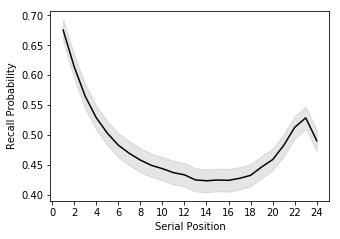

In [7]:
fig, ax = plt.subplots(figsize=[5,3.5])
ax.plot(range(1,25), np.mean(spc_all, 0), color='k')
err = scipy.stats.sem(spc_all, 0)
ax.fill_between(range(1,25), np.mean(spc_all, 0)-err, np.mean(spc_all, 0)+err, 
                color='k', alpha=0.1, edgecolor='none')
ax.set_xticks(range(0,25)[::2])
ax.set_xlabel('Serial Position')
ax.set_ylabel('Recall Probability')

# fig.savefig('figures_final/beh_enc_spc.pdf')

In [538]:
def get_subject_enc_subtype_pc(subject, conditional=False):
    # if conditional, return cluster subtype of recalled events only
    #     (effectively, the probability curves conditioned on SPC)
    print(subject, end=',')
    subject_data = enc_labeled_events[(enc_labeled_events['subject']==subject)]
    if conditional:
        subject_data = subject_data[subject_data['recalled']==1]
    sessions = np.unique(subject_data['session'])
    pc = {'BC':np.ones((len(sessions),24))*np.nan,
          'TC':np.ones((len(sessions),24))*np.nan,
          'SC':np.ones((len(sessions),24))*np.nan,
          'NC':np.ones((len(sessions),24))*np.nan,
          'NR':np.ones((len(sessions),24))*np.nan}
    item_types = pc.keys()
    for s, sess in enumerate(sessions):
        sess_data = subject_data[subject_data['session']==sess]
        trials = np.unique(sess_data['trial'])
        sess_pc = {'BC':np.ones((len(trials),24))*np.nan,
                   'TC':np.ones((len(trials),24))*np.nan,
                   'SC':np.ones((len(trials),24))*np.nan,
                   'NC':np.ones((len(trials),24))*np.nan,
                   'NR':np.ones((len(trials),24))*np.nan}
        
        for t, tr in enumerate(trials):
            trial_data = sess_data[sess_data['trial']==tr]
            if (not conditional) and (len(trial_data) != 24):
                print('uh oh, ', subject, sess, tr)
                continue
            for item in sess_pc.keys():
                tr_pc = np.ones(24)*np.nan
                for sp in trial_data['serialpos']:
                    tr_pc[sp-1] = int(trial_data[trial_data['serialpos']==sp]['cluster_type'].values[0]==item)
                sess_pc[item][t] = tr_pc # 1s and 0s for this subtype across a list
        
        for item in sess_pc.keys():
            pc[item][s] = np.nanmean(sess_pc[item], 0) # mean over lists in a session
    for item in pc.keys():
        pc[item] = np.nanmean(pc[item],0) # mean over sessions
    return pc

In [487]:
enc_subtype_pc = [get_subject_enc_subtype_pc(s) for s in FR2_valid_subjects]
# pkl.dump(enc_subtype_pc, open('data/enc_subtype_pc.pkl','wb'))

LTP093,LTP106,LTP115,LTP117,LTP123,LTP133,LTP138,LTP207,LTP210,LTP228,LTP229,LTP236,LTP246,LTP249,LTP250,LTP251,LTP258,LTP259,LTP265,LTP269,LTP273,LTP278,LTP279,LTP280,LTP283,LTP285,LTP287,LTP293,LTP296,LTP297,LTP299,LTP301,LTP302,LTP303,LTP304,LTP305,LTP306,LTP307,LTP310,LTP311,LTP312,LTP316,LTP317,LTP318,LTP321,LTP322,LTP323,LTP324,LTP325,LTP326,LTP327,LTP328,LTP329,LTP331,LTP334,LTP336,LTP339,LTP341,LTP342,LTP343,LTP344,LTP346,LTP347,LTP348,LTP349,LTP354,LTP355,LTP357,LTP360,LTP361,LTP362,LTP364,LTP365,LTP366,LTP367,LTP371,LTP372,LTP373,LTP374,LTP376,LTP377,LTP385,LTP386,LTP387,LTP389,LTP390,LTP391,LTP393,

In [542]:
enc_conditional_subtype_pc = [get_subject_enc_subtype_pc(s, conditional=True) for s in FR2_valid_subjects]
# pkl.dump(enc_subtype_pc, open('data/enc_conditional_subtype_pc.pkl','wb'))

LTP093,LTP106,LTP115,LTP117,LTP123,LTP133,LTP138,LTP207,LTP210,LTP228,LTP229,LTP236,LTP246,LTP249,LTP250,LTP251,LTP258,LTP259,LTP265,LTP269,LTP273,LTP278,LTP279,LTP280,LTP283,LTP285,LTP287,LTP293,LTP296,LTP297,LTP299,LTP301,LTP302,LTP303,LTP304,LTP305,LTP306,LTP307,LTP310,LTP311,LTP312,LTP316,LTP317,LTP318,LTP321,LTP322,LTP323,LTP324,LTP325,LTP326,LTP327,LTP328,LTP329,LTP331,LTP334,LTP336,LTP339,LTP341,LTP342,LTP343,LTP344,LTP346,LTP347,LTP348,LTP349,LTP354,LTP355,LTP357,LTP360,LTP361,LTP362,LTP364,LTP365,LTP366,LTP367,LTP371,LTP372,LTP373,LTP374,LTP376,LTP377,LTP385,LTP386,LTP387,LTP389,LTP390,LTP391,LTP393,

In [490]:
enc_BC_all = np.array([x['BC'] for x in enc_subtype_pc])
enc_TC_all = np.array([x['TC'] for x in enc_subtype_pc])
enc_SC_all = np.array([x['SC'] for x in enc_subtype_pc])
enc_NC_all = np.array([x['NC'] for x in enc_subtype_pc])
enc_NR_all = np.array([x['NR'] for x in enc_subtype_pc])

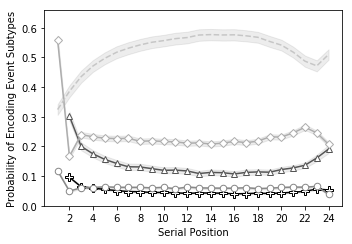

In [511]:
# encoding output by clustering type and serial position - plot 
fig, ax = plt.subplots(figsize=[5,3.5])

# mask BC_all and TC_all sp0 nan values as 0
enc_BC_all[:,0] = np.nan
enc_TC_all[:,0] = np.nan

values = [enc_BC_all, enc_TC_all, enc_SC_all, enc_NC_all, enc_NR_all]
labels=['BC','TC','SC','NC','NR']
colors=['k','#555555','#888888','#adadad','#c6c6c6']
markers=['P','^','o','D','']
markersizes=[7.5,6.5,6.5,5.5,0]
linestyles=['-','-','-','-','--']

for i, x in enumerate(values):
    
    ax.plot(range(24), np.nanmean(x, 0), ls=linestyles[i],
            marker=markers[i], ms=markersizes[i], mfc='w', 
            color=colors[i], label=labels[i])
    err = scipy.stats.sem(x, axis=0, nan_policy='omit')
    ax.fill_between(range(24), np.nanmean(x, 0)-err, np.nanmean(x, 0)+err, color='k', alpha=0.07, edgecolor='w')

# ax.axhline(y=0.5, ls='--', lw=0.75, color='gray')

ax.set_xticks(range(24)[1::2])
ax.set_xticklabels(np.arange(1,25,1)[1::2])
ax.set_ylim([0.0,0.66])
ax.set_xlabel('Serial Position')
ax.set_ylabel('Probability of Encoding Event Subtypes')

# ax.legend(ncol=1, loc=3, fontsize='medium')
fig.tight_layout()

In [512]:
# fig.savefig('figures_final/beh_enc_subtype_pc.pdf')

In [543]:
enc_BC_all = np.array([x['BC'] for x in enc_conditional_subtype_pc])
enc_TC_all = np.array([x['TC'] for x in enc_conditional_subtype_pc])
enc_SC_all = np.array([x['SC'] for x in enc_conditional_subtype_pc])
enc_NC_all = np.array([x['NC'] for x in enc_conditional_subtype_pc])

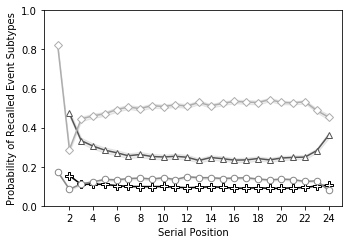

In [564]:
# encoding output by clustering type and serial position - plot 
fig, ax = plt.subplots(figsize=[5,3.5])

# mask BC_all and TC_all sp0 nan values as 0
enc_BC_all[:,0] = np.nan
enc_TC_all[:,0] = np.nan

values = [enc_BC_all, enc_TC_all, enc_SC_all, enc_NC_all]
labels=['BC','TC','SC','NC']
colors=['k','#555555','#888888','#adadad']
markers=['P','^','o','D']
markersizes=[7.5,6.5,6.5,5.5]
linestyles=['-','-','-','-']

for i, x in enumerate(values):
    
    ax.plot(range(24), np.nanmean(x, 0), ls=linestyles[i],
            marker=markers[i], ms=markersizes[i], mfc='w', 
            color=colors[i], label=labels[i])
    err = scipy.stats.sem(x, axis=0, nan_policy='omit')
    ax.fill_between(range(24), np.nanmean(x, 0)-err, np.nanmean(x, 0)+err, color='k', alpha=0.07, edgecolor='w')

# ax.axhline(y=0.5, ls='--', lw=0.75, color='gray')

ax.set_xticks(range(24)[1::2])
ax.set_xticklabels(np.arange(1,25,1)[1::2])
ax.set_ylim([0.0,1])
ax.set_xlabel('Serial Position')
ax.set_ylabel('Probability of Recalled Event Subtypes')

# ax.legend(ncol=1, loc=3, fontsize='medium')
fig.tight_layout()

In [565]:
# fig.savefig('figures_final/beh_enc_conditional_subtype_pc.pdf')

In [361]:
def get_subject_ret_dist(subject):
    # the probability that a given recall response (correct or intrusion, aggregated)
    # comes from a particular bin
    print(subject, end=', ')
    rectime_bins = np.arange(0, 75.1, 7.5)*1000
    
    subject_data = ret_labeled_events[(ret_labeled_events['subject']==subject)]
    pc = np.zeros((len(np.unique(subject_data['session'])),10))
    for s, sess in enumerate(np.unique(subject_data['session'])):
        sess_data = subject_data[subject_data['session']==sess]
        sess_pc = np.zeros((len(np.unique(sess_data['trial'])),10))
        for t, trial in enumerate(np.unique(sess_data['trial'])):
            # probability of a recalled word being in a given recall bin
            # i.e., probability of all bins sums to 1
            rectimes = sess_data[sess_data['trial']==trial]['rectime']
            if len(rectimes)==0: continue # zero recall response in this trial
            tr_pc = [sum((rectimes>rectime_bins[b-1])&(rectimes<=rectime_bins[b]))/len(rectimes) for b in range(1,11)]
            sess_pc[t] = tr_pc
        pc[s] = np.nanmean(sess_pc, 0)
    return np.nanmean(pc, 0)

def get_subject_ret_pc(subject):
    # the probability that a recall response was correct vs. intrusion
    rectime_bins = np.arange(0, 75.1, 7.5)*1000
    pc = []
    events = ret_labeled_events[ret_labeled_events['subject']==subject]
    for sess in np.unique(events['session']):
        sess_events = events[events['session']==sess]
        sess_pc = []
        for tr in np.unique(sess_events['trial']):
            tr_events = sess_events[sess_events['trial']==tr]
            tr_pc = [np.mean(tr_events[(tr_events['rectime']>rectime_bins[b-1])&(tr_events['rectime']<=rectime_bins[b])]['intrusion']==0) 
                     for b in range(1,11)]
            sess_pc.append(tr_pc)
        pc.append(np.nanmean(sess_pc, 0))
    return np.nanmean(pc, 0)

In [364]:
ret_dist_all = np.array([get_subject_ret_dist(s) for s in FR2_valid_subjects])
# np.save('data/ret_dist_all.npy', ret_dist_all)

LTP093, LTP106, LTP115, LTP117, LTP123, LTP133, LTP138, LTP207, LTP210, LTP228, LTP229, LTP236, LTP246, LTP249, LTP250, LTP251, LTP258, LTP259, LTP265, LTP269, LTP273, LTP278, LTP279, LTP280, LTP283, LTP285, LTP287, LTP293, LTP296, LTP297, LTP299, LTP301, LTP302, LTP303, LTP304, LTP305, LTP306, LTP307, LTP310, LTP311, LTP312, LTP316, LTP317, LTP318, LTP321, LTP322, LTP323, LTP324, LTP325, LTP326, LTP327, LTP328, LTP329, LTP331, LTP334, LTP336, LTP339, LTP341, LTP342, LTP343, LTP344, LTP346, LTP347, LTP348, LTP349, LTP354, LTP355, LTP357, LTP360, LTP361, LTP362, LTP364, LTP365, LTP366, LTP367, LTP371, LTP372, LTP373, LTP374, LTP376, LTP377, LTP385, LTP386, LTP387, LTP389, LTP390, LTP391, LTP393, 

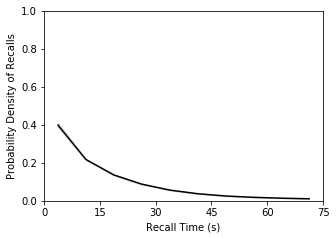

In [369]:
fig, ax = plt.subplots(figsize=[5,3.5])
ax.plot(np.arange(7.5, 75.1, 7.5)-7.5/2, np.mean(ret_dist_all, 0), color='k')
err = scipy.stats.sem(ret_dist_all, 0)
ax.fill_between(np.arange(7.5, 75.1, 7.5)-7.5/2, np.mean(ret_dist_all, 0)-err, np.mean(ret_dist_all, 0)+err, 
                color='k', alpha=0.1, edgecolor='none')
ax.set_xticks(np.arange(0, 76, 15))
ax.set_ylim(0, 1)
# ax.set_yticks(np.arange(0.8,1.01,0.05))
ax.set_xlabel('Recall Time (s)')
ax.set_ylabel('Probability Density of Recalls')

# fig.savefig('figures_final/beh_ret_dist.pdf')

In [344]:
ret_spc_all = np.array([get_subject_ret_pc(s) for s in FR2_valid_subjects])
# np.save('data/ret_ci_pc.npy', ret_spc_all)

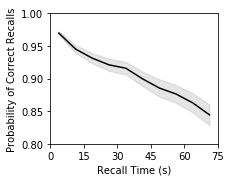

In [373]:
fig, ax = plt.subplots(figsize=[3,2.4])
ax.plot(np.arange(7.5, 75.1, 7.5)-7.5/2, np.mean(ret_spc_all, 0), color='k')
err = scipy.stats.sem(ret_spc_all, 0)
ax.fill_between(np.arange(7.5, 75.1, 7.5)-7.5/2, np.mean(ret_spc_all, 0)-err, np.mean(ret_spc_all, 0)+err, 
                color='k', alpha=0.1, edgecolor='none')
ax.set_xticks(np.arange(0, 76, 15))
ax.set_ylim(0.8, 1)
ax.set_yticks(np.arange(0.8,1.01,0.05))
ax.set_xlabel('Recall Time (s)')
ax.set_ylabel('Probability of Recall/Intrusion Subtypes')

# fig.savefig('figures_final/beh_ret_cipc.pdf', bbox_inches="tight", transparent=True)

In [429]:
def get_subject_ret_subtype_pc(subject):
    print(subject, end=',')
    # the probability that a recall response was pli, eli, BC, TC, SC, NC
    
    rectime_bins = np.arange(0, 75.1, 7.5)*1000
    subject_data = ret_labeled_events[(ret_labeled_events['subject']==subject)]
    sessions = np.unique(subject_data['session'])
    pc = {'BC':np.ones((len(sessions),10))*np.nan,
          'TC':np.ones((len(sessions),10))*np.nan,
          'SC':np.ones((len(sessions),10))*np.nan,
          'NC':np.ones((len(sessions),10))*np.nan,
          'PLI':np.ones((len(sessions),10))*np.nan,
          'ELI':np.ones((len(sessions),10))*np.nan}
    item_types = pc.keys()
    for s, sess in enumerate(sessions):
        sess_data = subject_data[subject_data['session']==sess]
        trials = np.unique(sess_data['trial'])
        sess_pc = {'BC':np.ones((len(trials),10))*np.nan,
                   'TC':np.ones((len(trials),10))*np.nan,
                   'SC':np.ones((len(trials),10))*np.nan,
                   'NC':np.ones((len(trials),10))*np.nan,
                   'PLI':np.ones((len(trials),10))*np.nan,
                   'ELI':np.ones((len(trials),10))*np.nan}
        
        for t, tr in enumerate(trials):
            rectimes_all = sess_data[sess_data['trial']==tr]['rectime']
            for item in sess_pc.keys():
                if item=='PLI': rectimes_item = sess_data[(sess_data['trial']==tr)&(sess_data['intrusion']>0)]['rectime']
                elif item=='ELI': rectimes_item = sess_data[(sess_data['trial']==tr)&(sess_data['intrusion']<0)]['rectime']
                else: rectimes_item = sess_data[(sess_data['trial']==tr)&(sess_data['cluster_type']==item)]['rectime']
                tr_pc = []
                for b in range(1,11):
                    # probability of a recall response being that item (pli/eli/cluster_types) in a given interval
                    # i.e., probability of all types in a given bin sums to 1
                    n_recall = sum((rectimes_all>rectime_bins[b-1])&(rectimes_all<=rectime_bins[b]))
                    n_item = sum((rectimes_item>rectime_bins[b-1])&(rectimes_item<=rectime_bins[b]))
                    tr_pc.append(n_item/n_recall if n_recall!=0 else np.nan)
                sess_pc[item][t] = tr_pc # probability for this subtype across recall bins
        
        for item in sess_pc.keys():
            pc[item][s] = np.nanmean(sess_pc[item], 0) # mean over trials in a session
    for item in pc.keys():
        pc[item] = np.nanmean(pc[item],0) # mean over sesssions
    return pc

In [ ]:
ret_subtype_pc = [get_subject_ret_subtype_pc(s) for s in FR2_valid_subjects]
# pkl.dump(ret_subtype_pc, open('data/ret_subtype_pc.pkl','wb'))

In [440]:
ret_BC_all = np.array([x['BC'] for x in ret_subtype_pc])
ret_TC_all = np.array([x['TC'] for x in ret_subtype_pc])
ret_SC_all = np.array([x['SC'] for x in ret_subtype_pc])
ret_NC_all = np.array([x['NC'] for x in ret_subtype_pc])
ret_pli_all = np.array([x['PLI'] for x in ret_subtype_pc])
ret_eli_all = np.array([x['ELI'] for x in ret_subtype_pc])

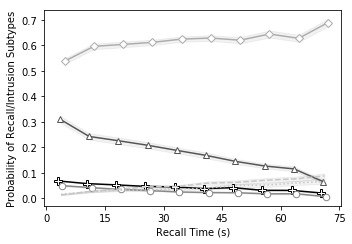

In [510]:
fig, ax = plt.subplots(figsize=[5,3.5])

values = [ret_BC_all, ret_TC_all, ret_SC_all, ret_NC_all, ret_pli_all, ret_eli_all]
labels=['BC','TC','SC','NC','PLI','ELI']
colors=['k','#555555','#888888','#adadad','#c6c6c6','#c6c6c6']
markers=['P','^','o','D','','']
markersizes=[7.5,6.5,6.5,5.5,0,0]
linestyles=['-','-','-','-','--',':']

xticks = np.arange(7.5, 75.1, 7.5)-7.5/2
jitter = [-0.9,-0.3,0.3,0.9,0,0]

for i, x in enumerate(values):
    
    ax.plot(xticks+jitter[i], np.nanmean(x, 0), ls=linestyles[i],
            marker=markers[i], ms=markersizes[i], mfc='w', 
            color=colors[i], label=labels[i])
    err = scipy.stats.sem(x, axis=0, nan_policy='omit')
    ax.fill_between(xticks+jitter[i], np.nanmean(x, 0)-err, np.nanmean(x, 0)+err, 
                    color='k', alpha=0.05, edgecolor='none')

# ax.set_ylim([0.43,0.524])
ax.set_xticks(np.arange(0,76,15))
ax.set_xticklabels(np.arange(0,76,15))
ax.set_xlabel('Recall Time (s)')
ax.set_ylabel('Probability of Recall/Intrusion Subtypes')

# ax.legend(loc=3, fontsize='medium')
fig.tight_layout()

# fig.savefig('figures_final/beh_ret_subtype_pc.pdf')

### expand group univariate SME heatmaps with event resampling and along time dimension

In [59]:
def FR2_univariate_tstats_resample(subject, task, ret_type='ci'):
    
    import os
    import glob
    import scipy.stats
    import numpy as np
    import pandas as pd
    import xarray as xr
    import pickle as pkl
    
    from constants import ROIs
    from utils import load_feature, split_ROIs, get_eeg_sys, resample_enc_events, resample_ret_events
    
    features = load_feature(subject, task_phase=task, ret_type=ret_type,
                            exclude_peripheral_channels=False, stack_feature=False)
    features = split_ROIs(features, sys=get_eeg_sys(subject))
    
    if task == 'enc':
        features = resample_enc_events(features) # resample events to ensure similar pos/neg ratio at each serialpos
    if task == 'ret':
        features = resample_ret_events(features) # resample events to ensure similar pos/neg ratio in each rectime bin
    
    features = features.sel(events=features.events.values['serialpos']<5)
    label = 'recalled' if task=='enc' else 'rec_label'
    positive_events = features.sel(events=features.events.values[label]==1)
    negative_events = features.sel(events=features.events.values[label]==0)

    tvals = scipy.stats.ttest_ind(positive_events, negative_events, axis=1).statistic # along events axis
    tvals = xr.DataArray(tvals, dims=['ROI','frequency'],
                         coords={'ROI':negative_events.ROI.values,
                                 'frequency':negative_events.frequency.values})
    
    return tvals

In [60]:
tstats = [FR2_univariate_tstats_resample(s, task='enc', ret_type='ci') 
          for s in FR2_valid_subjects]

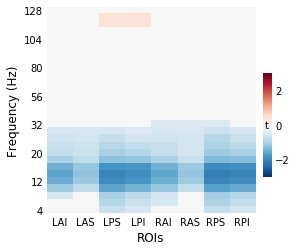

In [61]:
fig, ax = plot_heatmap_contrast([s.sel(frequency=s.frequency>2) for s in tstats], vmin=-3, vmax=3, figsize=[4.2,3.6])

In [62]:
# fig.savefig('figures_final/univar_enc_resample_sp1-4.pdf')

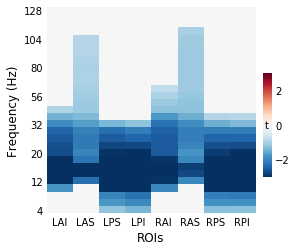

In [7]:
fig, ax = plot_heatmap_contrast([s.sel(frequency=s.frequency>2) for s in tstats], vmin=-3, vmax=3, figsize=[4.2,3.6])

In [8]:
# fig.savefig('figures_final/univar_enc_resample.pdf')

In [10]:
tstats = [FR2_univariate_tstats_resample(s, task='ret', ret_type='ci') 
          for s in FR2_valid_subjects]

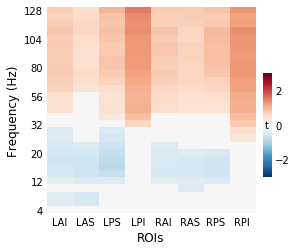

In [11]:
fig, ax = plot_heatmap_contrast([s.sel(frequency=s.frequency>2) for s in tstats], vmin=-3, vmax=3, figsize=[4.2,3.6])

In [12]:
# fig.savefig('figures_final/univar_retci_resample.pdf')

In [112]:
def FR2_univariate_tstats_over_time(subject):
    
    task = 'ret'
    resample = True
    
    # time-frequency SME
    
    import os
    import glob
    import scipy.stats
    import numpy as np
    import pandas as pd
    import xarray as xr
    import pickle as pkl
    
    from constants import ROIs, subjects_powerfile_elsewhere
    from utils import split_ROIs, get_eeg_sys, special_concat, resample_enc_events, resample_ret_events
    
    def concat_power_preserve_time():
        
        def filter_recalls(x):
            '''x is assumed to be a recall EEG timeseries
               filters x based on some recall exclusion criteria
            '''
            events = x.events.values
            keep_index = np.zeros(len(events), dtype=bool)

            # read events in again to get REC_VV vocalization events
            reader = cml.CMLReader(subject=np.unique(events['subject'])[0], 
                                   experiment='ltpFR2',
                                   session=np.unique(events['session'])[0])
            original_events = reader.load('events')
            original_events = original_events[(original_events['type']=='REC_WORD') | (original_events['type']=='REC_WORD_VV')]

            for trial in np.unique(events['trial']):
                trial_recs = events[events['trial']==trial]
                trial_recs_vvs = original_events[original_events['trial']==trial]

                # get timebefore w.r.t. onset of last recall for rec_word events
                rectimes = trial_recs_vvs['rectime']
                timebefore = np.diff(np.append([0], rectimes))
                timebefore = timebefore[trial_recs_vvs['type']=='REC_WORD']

                trial_valid_rec_flag = np.ones(len(trial_recs), dtype=bool)
                trial_valid_rec_flag[timebefore<1000] = 0

                keep_index[events['trial']==trial] = trial_valid_rec_flag

            x = x.sel(events=keep_index)

            return x

        if task == 'enc':

            if subject in subjects_powerfile_elsewhere:
                files = glob.glob('scratch/mtpower/%s/*_enc_logmtpowerts*.pkl' % subject)
            else:
                files =glob.glob('/scratch/liyuxuan/ltpFR2/mtpower/%s/*_enc_logmtpowerts*.pkl' % subject)

            power_all = []
            for f in files:

                try:
                    x = pkl.load(open(f,'rb'))

                    # technically covers 0 ~ 1600
                    x = x.sel(time=(x.time>=250)&(x.time<=1350))

                    means = x.mean('events')
                    stds = x.std('events')
                    x = (x-means)/stds

                    power_all.append(x)

                except Exception as e:
                    print(e)
                    continue

            power_all = special_concat(power_all)
            return power_all

        if task == 'ret':

            if subject in subjects_powerfile_elsewhere:
                files = glob.glob('scratch/mtpower/%s/*_ret_logmtpowerts*.pkl' % subject)
            else:
                files = glob.glob('/scratch/liyuxuan/ltpFR2/mtpower/%s/*_ret_logmtpowerts*.pkl' % subject)

            power_all = []
            for f in files:

                try:
                    x = pkl.load(open(f,'rb'))

                    # preserve events with no overlap w/ vocalization only
                    x = filter_recalls(x)

                    # technically covers -1000 ~ 0
                    x = x.sel(time=(x.time>=-750)&(x.time<=-250))

                    means = x.mean('events')
                    stds = x.std('events')
                    x = (x-means)/stds

                    power_all.append(x)

                except Exception as e:
                    print(e)
                    continue

            power_all = special_concat(power_all)
            return power_all
    
    features = concat_power_preserve_time()
    
    if task=='ret':
        new_labels = np.zeros(len(features.events.values))
        new_labels[features.events.values['intrusion']==0] = 1
        features.coords['events'] = append_fields(features.events.values, 
                                                  'rec_label', new_labels, usemask=False)
    
    if resample and task=='enc':
        features = resample_enc_events(features)
    if resample and task=='ret':
        features = resample_ret_events(features)
    
    features = split_ROIs(features, sys=get_eeg_sys(subject)).mean('ROI')
    
    label = 'recalled' if task=='enc' else 'rec_label'
    positive_events = features.sel(events=features.events.values[label]==1)
    negative_events = features.sel(events=features.events.values[label]==0)
    
    try:
        tvals = scipy.stats.ttest_ind(positive_events, negative_events, axis=1).statistic # along events axis, [time, events, frequency]
        tvals = xr.DataArray(tvals, dims=['time', 'frequency'],
                             coords={'time':negative_events.time.values,
                                     'frequency':negative_events.frequency.values})
    except:
        # no intrusion made...
        # print(positive_events.shape, negative_events.shape)
        return None
    
    # pkl.dump(tvals, open('scratch/mtpower/%s/%s_%s_resample_univar_tvals_timefreq.pkl'%(subject,subject,task), 'wb'))
    return tvals

In [113]:
for subject in FR2_valid_subjects:
    print(subject, end=',')
    FR2_univariate_tstats_over_time(subject)

LTP093,LTP106,LTP115,LTP117,LTP123,LTP133,LTP138,LTP207,LTP210,LTP228,LTP229,LTP236,LTP246,LTP249,LTP250,LTP251,LTP258,LTP259,LTP265,LTP269,LTP273,LTP278,LTP279,LTP280,LTP283,LTP285,LTP287,LTP293,LTP296,LTP297,LTP299,LTP301,LTP302,LTP303,LTP304,LTP305,LTP306,LTP307,LTP310,LTP311,LTP312,LTP316,LTP317,LTP318,LTP321,LTP322,LTP323,LTP324,LTP325,LTP326,LTP327,LTP328,LTP329,LTP331,LTP334,LTP336,LTP339,LTP341,LTP342,LTP343,LTP344,LTP346,LTP347,LTP348,LTP349,LTP354,LTP355,LTP357,LTP360,LTP361,LTP362,LTP364,LTP365,LTP366,LTP367,LTP371,LTP372,LTP373,LTP374,LTP376,LTP377,LTP385,LTP386,LTP387,LTP389,LTP390,LTP391,LTP393,

In [86]:
def plot_heatmap_contrast_special_tf(results, vmin, vmax):
    
    # made special for time-frequency plots
    
    def get_FDR_sigmatrix(X):
        tvals, pvals = scipy.stats.ttest_1samp(X, 0, axis=0, nan_policy='omit')
        reject, pval_corrected = mne.stats.fdr_correction(pvals.flatten())
        sigmatrix = reject.reshape(pvals.shape)
        return tvals, sigmatrix
    
    def imshow_wrapper(ax, valuematrix, sigmatrix, vmin, vmax, cmap):
        
        sig_region = np.ma.masked_where(~sigmatrix, valuematrix)
        nonsig_region = np.ma.masked_where(sigmatrix, valuematrix)
        ax.imshow(sig_region, origin='lower', aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
        ax.imshow(nonsig_region, origin='lower', aspect='auto', cmap=cmap, alpha=1, vmin=-100000, vmax=100000)
        hide_spines_and_ticks(ax)
        return ax
    
    def hide_spines_and_ticks(ax):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(axis=u'both', which=u'both',length=0)
    
    fig, ax = plt.subplots(figsize=[6,3.6])
    
    # concat along subject dim
    X = xr.concat(results, dim='subjects')
    tvals, sig_matrix = get_FDR_sigmatrix(X.values)
    
    # plot average relative t-test tstat
    ax = imshow_wrapper(ax, X.mean('subjects').T, sig_matrix.T, vmin=vmin, vmax=vmax, cmap='RdBu_r')
    
    freqs = results[0].frequency.values
    times = results[0].time.values
    ax.set_yticklabels([])
    ax.set_yticks(range(len(freqs))[::4])
    ax.set_yticklabels(['%d'%f for f in freqs[::4]])
    ax.set_ylabel('Frequency (Hz)', size=12)
    ax.set_xticks(range(len(times))[::2])
    ax.set_xticklabels(times[::2])
    ax.set_xlabel('Time (ms)', size=12)

    return fig, ax

In [90]:
files = glob.glob('scratch/mtpower/*/*_enc_univar_tvals_timefreq.pkl')
tvals = [pkl.load(open(f,'rb'))for f in files]

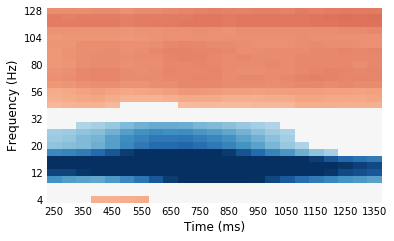

In [91]:
fig, ax = plot_heatmap_contrast_special_tf([s.sel(frequency=s.frequency>2) for s in tvals], 
                                         vmin=-3, vmax=3)

In [93]:
# fig.savefig('figures_final/univar_tf_enc.pdf', bbox_inches="tight")

In [114]:
files = glob.glob('scratch/mtpower/*/LTP[0-9][0-9][0-9]_ret_univar_tvals_timefreq.pkl')
tvals = [pkl.load(open(f,'rb'))for f in files]

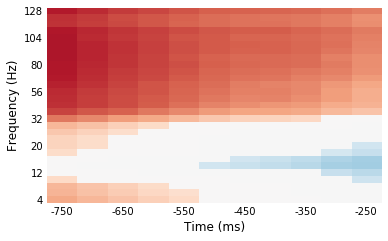

In [116]:
fig, ax = plot_heatmap_contrast_special_tf([s.sel(frequency=s.frequency>2) for s in tvals], 
                                         vmin=-3, vmax=3)

In [117]:
# fig.savefig('figures_final/univar_tf_ret.pdf', bbox_inches="tight")

In [133]:
files = glob.glob('scratch/mtpower/*/LTP[0-9][0-9][0-9]_enc_resample_univar_tvals_timefreq.pkl')
tvals = [pkl.load(open(f,'rb'))for f in files]

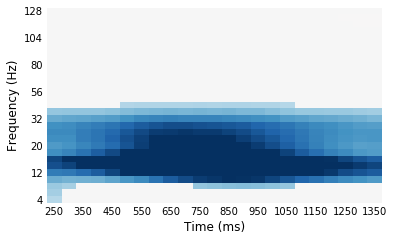

In [135]:
fig, ax = plot_heatmap_contrast_special_tf([s.sel(frequency=s.frequency>2) for s in tvals], 
                                         vmin=-3, vmax=3)

In [136]:
# fig.savefig('figures_final/univar_tf_resample_enc.pdf', bbox_inches="tight")

In [122]:
files = glob.glob('scratch/mtpower/*/LTP[0-9][0-9][0-9]_ret_resample_ret_univar_tvals_timefreq.pkl')
tvals = [pkl.load(open(f,'rb'))for f in files]

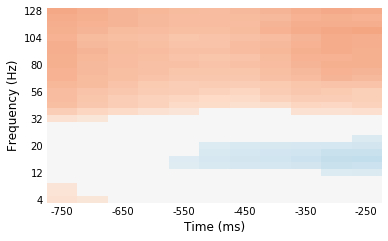

In [123]:
fig, ax = plot_heatmap_contrast_special_tf([s.sel(frequency=s.frequency>2) for s in tvals], 
                                         vmin=-3, vmax=3)

In [121]:
# fig.savefig('figures_final/univar_tf_resample_ret.pdf', bbox_inches="tight")

In [16]:
def FR2_univariate_tstats_over_serialpos_recbin(subject, task, ret_type='ci', t=None):
    
    # for encoding t is serialpos
    # for retrieval t is retrieval bin (7.5s), 10 bins, numbered 1-10
    
    import os
    import glob
    import scipy.stats
    import numpy as np
    import pandas as pd
    import xarray as xr
    import pickle as pkl
    
    from constants import ROIs
    from utils import load_feature, split_ROIs, get_eeg_sys
    
    features = load_feature(subject, task_phase=task, ret_type=ret_type,
                            exclude_peripheral_channels=False, stack_feature=False)
    if t is not None:
        if task=='enc':
            features = features.sel(events=(features.events.values['serialpos']==t))
        elif task=='ret':
            rectime_bins = np.arange(0, 75.1, 7.5)*1000
            tmin = rectime_bins[t-1]
            tmax = rectime_bins[t]
            features = features.sel(events=(features.events.values['rectime']>tmin)&(features.events.values['rectime']<=tmax))
    features = split_ROIs(features, sys=get_eeg_sys(subject)).mean('ROI')
    
    label = 'recalled' if task=='enc' else 'rec_label'
    positive_events = features.sel(events=features.events.values[label]==1)
    negative_events = features.sel(events=features.events.values[label]==0)
    
    try:
        tvals = scipy.stats.ttest_ind(positive_events, negative_events, axis=0).statistic # along events axis
        tvals = xr.DataArray(tvals, dims=['frequency'],
                             coords={'frequency':negative_events.frequency.values})
    except:
        # no intrusion made...
        # print(positive_events.shape, negative_events.shape)
        return None
    
    return tvals

def plot_heatmap_contrast_special(results, vmin, vmax, t):
    
    # made special for per serialpos/recbin plots... really just the xtick...
    
    def get_FDR_sigmatrix(X):
        tvals, pvals = scipy.stats.ttest_1samp(X, 0, axis=0, nan_policy='omit')
        reject, pval_corrected = mne.stats.fdr_correction(pvals.flatten())
        sigmatrix = reject.reshape(pvals.shape)
        return tvals, sigmatrix
    
    def imshow_wrapper(ax, valuematrix, sigmatrix, vmin, vmax, cmap):
        
        # expand to (1, len) shape for imshow (because we removed the ROI dim)
        valuematrix = np.expand_dims(valuematrix,0).T
        sigmatrix = np.expand_dims(sigmatrix,0).T
        
        sig_region = np.ma.masked_where(~sigmatrix, valuematrix)
        nonsig_region = np.ma.masked_where(sigmatrix, valuematrix)
        ax.imshow(sig_region, origin='lower', aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
        ax.imshow(nonsig_region, origin='lower', aspect='auto', cmap=cmap, alpha=1, vmin=-100000, vmax=100000)
        hide_spines_and_ticks(ax)
        return ax
    
    def hide_spines_and_ticks(ax):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(axis=u'both', which=u'both',length=0)
    
    fig, ax = plt.subplots(figsize=[0.62,4])
    
    # concat along subject dim
    X = xr.concat(results, dim='subjects')
    tvals, sig_matrix = get_FDR_sigmatrix(X.values)
    
    # plot average relative t-test tstat
    ax = imshow_wrapper(ax, X.mean('subjects').T, sig_matrix.T, vmin=vmin, vmax=vmax, cmap='RdBu_r')
    
    freqs = results[0].frequency.values
    ax.set_yticklabels([])
    ax.set_yticks(range(len(freqs))[::4])
    ax.set_yticklabels(['%d'%f for f in freqs[::4]])
    ax.set_xticks(range(1))
    ax.set_xticklabels(['%d'%t])
    ax.set_ylabel('Frequency (Hz)', size=12)

    return fig, ax

1,

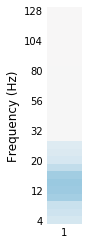

In [8]:
# for t in range(1,25):
t = 1
print(t, end=',')
tstats = [FR2_univariate_tstats_over_serialpos_recbin(s, task='enc', ret_type='ci', t=t) for s in FR2_valid_subjects]
fig, ax = plot_heatmap_contrast_special([s.sel(frequency=s.frequency>2) for s in tstats], 
                                         vmin=-3, vmax=3, t=t)

# fig.savefig('figures_final/univar_enc_sp%d.pdf'%t, bbox_inches="tight")

1,

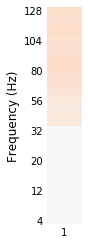

In [17]:
# for t in range(6,11):
t = 1
print(t, end=',')
tstats = [FR2_univariate_tstats_over_serialpos_recbin(s, task='ret', ret_type='ci', t=t) for s in FR2_valid_subjects]
tstats = [x for x in tstats if x is not None]
# bin 6 - 2 subjects
# bin 7 - 1 subject
# bin 8 - 4 subjects
# bin 9 - 6 subjects
# bin 10 - 8 subjects
fig, ax = plot_heatmap_contrast_special([s.sel(frequency=s.frequency>2) for s in tstats], vmin=-3, vmax=3, t=t)

# fig.savefig('figures_final/univar_retci_bin%d.pdf'%t, bbox_inches="tight")

### alternative classification: re-sample events to ensure the same proportion of positive/negative events across serial positions or recall bins

In [223]:
def FR2_individual_classifier_resample(subject):
    
    # global flags
    train_phase = 'ret'
    test_phase = 'ret'
    ret_type = ['ci', 'cp', 'ce', 'pe'][0] # 'correct vs. incorrect', 'correct vs. pli', 'correct vs. eli', 'pli vs. eli'
    train_label = 'recalled' if train_phase=='enc' else 'rec_label'
    test_label = 'recalled' if test_phase=='enc' else 'rec_label'
    
    import pickle as pkl
    import numpy as np
    import pandas as pd
    import xarray as xr
    from sklearn.metrics import roc_auc_score
    
    from constants import best_C
    from utils import load_feature, divide_folds, compute_activation, leave_one_session_out_forward_model, \
                      resample_enc_events, resample_ret_events

    for run_id in range(1,21):
        
        train_features = load_feature(subject, task_phase=train_phase, ret_type=ret_type,
                                      exclude_sessions=[23], exclude_freq=[2.0], 
                                      exclude_peripheral_channels=True, stack_feature=True)
        test_features = load_feature(subject, task_phase=test_phase, ret_type=ret_type,
                                      exclude_sessions=[23], exclude_freq=[2.0], 
                                      exclude_peripheral_channels=True, stack_feature=True)
        
        if train_phase == 'enc':
            train_features = resample_enc_events(train_features) # resample events to ensure similar pos/neg ratio at each serialpos
        if train_phase == 'ret':
            train_features = resample_ret_events(train_features) # resample events to ensure similar pos/neg ratio in each rectime bin
            
        # retrieval classifiers have this problem where events in sessions with very few intrusions doesn't get selected during the resampling process
        # match test data sessions with resampled training data for cross-validation match
        test_features = test_features.sel(events=np.in1d(test_features.events.values['session'], np.unique(train_features.events.values['session'])))

        y_hat, y, weights, activations = leave_one_session_out_forward_model(train_features=train_features, 
                                                                             train_label=train_label, 
                                                                             test_features=test_features, 
                                                                             test_label=test_label,
                                                                             C=best_C)
        # compute average weights and average activation values
        avgW = xr.DataArray(weights.mean(0), dims=('features'), coords={'features':test_features.features})
        avgW = avgW.unstack('features')
        avgA = xr.DataArray(activations.mean(0), dims=('features'), coords={'features':test_features.features})
        avgA = avgA.unstack('features')

        auc = roc_auc_score(y, y_hat)

        subject_loso_result = {}
        subject_loso_result['auc'] = auc
        subject_loso_result['y'] = y
        subject_loso_result['yhat'] = y_hat
        subject_loso_result['train_events'] = train_features.events.values
        subject_loso_result['test_events'] = test_features.events.values
        subject_loso_result['avgW'] = avgW
        subject_loso_result['avgA'] = avgA

        if train_phase == 'ret':
            train_phase_outstr = train_phase + ret_type
        if test_phase == 'ret':
            test_phase_outstr = test_phase + ret_type
        
        outputf = 'scratch/mtpower/%s/%s_%s_%s_clsf_resample_run%d_result.pkl' % \
                  (subject, subject, train_phase_outstr, test_phase_outstr, run_id)
        # pkl.dump(subject_loso_result, open(outputf, 'wb'))

def FR2_classifier_resample_nullauc(subject):
    
    # global flags
    train_phase = 'ret'
    test_phase = 'ret'
    ret_type = ['ci', 'cp', 'ce', 'pe'][0] # 'correct vs. incorrect', 'correct vs. pli', 'correct vs. eli', 'pli vs. eli'
    n_tests = 10
    
    train_label = 'recalled' if train_phase=='enc' else 'rec_label'
    test_label = 'recalled' if test_phase=='enc' else 'rec_label'

    import pickle as pkl
    import numpy as np
    import pandas as pd
    import xarray as xr
    from sklearn.metrics import roc_auc_score
    
    from constants import best_C
    from utils import load_feature, divide_folds, compute_activation, shuffle_labels, \
                      leave_one_session_out_forward_model, resample_enc_events, resample_ret_events
    
    # perform n_tests many of permutation tests
    aucs_null = np.zeros(n_tests)
    for i in range(len(aucs_null)):
        
        train_features = load_feature(subject, task_phase=train_phase, ret_type=ret_type,
                                      exclude_sessions=[23], exclude_freq=[2.0], 
                                      exclude_peripheral_channels=True, stack_feature=True)
        test_features = load_feature(subject, task_phase=test_phase, ret_type=ret_type,
                                      exclude_sessions=[23], exclude_freq=[2.0], 
                                      exclude_peripheral_channels=True, stack_feature=True)
        
        if train_phase == 'enc':
            train_features = resample_enc_events(train_features) # resample events to ensure similar pos/neg ratio at each serialpos
        if train_phase == 'ret':
            train_features = resample_ret_events(train_features) # resample events to ensure similar pos/neg ratio in each rectime bin
        
        # retrieval classifiers have this problem where events in sessions with very few intrusions doesn't get selected during the resampling process
        # match test data sessions with resampled training data for cross-validation match
        test_features = test_features.sel(events=np.in1d(test_features.events.values['session'], np.unique(train_features.events.values['session'])))
        
        shuffled_events = shuffle_labels(train_features.events.values.copy(), train_label)
        train_features.coords['events'] = shuffled_events

        y_hat, y, weights, activations = leave_one_session_out_forward_model(train_features=train_features, 
                                                                             train_label=train_label, 
                                                                             test_features=test_features, 
                                                                             test_label=test_label,
                                                                             C=best_C)
        
        aucs_null[i] = roc_auc_score(y, y_hat)
    
    if train_phase == 'ret':
        train_phase = train_phase + ret_type
    if test_phase == 'ret':
        test_phase = test_phase + ret_type

    outputf = 'scratch/mtpower/%s/%s_%s_%s_resample_null_aucs.npy' % (subject, subject, train_phase, test_phase)
    # np.save(outputf, aucs_null)

In [ ]:
subjects = FR2_valid_subjects
njobs = len(subjects)
cpj = 1
with cluster_helper.cluster.cluster_view(scheduler='sge', queue='RAM.q', 
                                         num_jobs=njobs, cores_per_job=cpj) as view:
    result = view.map(FR2_classifier_resample, subjects)

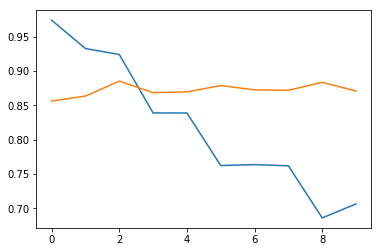

In [192]:
plt.figure()
rectime_bins = np.arange(0, 75.1, 7.5)*1000
plt.plot(range(10), [np.mean(events[(events['rectime']>rectime_bins[b-1])&(events['rectime']<=rectime_bins[b])]['rec_label']) 
                     for b in range(1,11)], color='C0', label='original')
plt.plot(range(10), [np.mean(resampled_events[(resampled_events['rectime']>rectime_bins[b-1])&(resampled_events['rectime']<=rectime_bins[b])]['rec_label']) 
                     for b in range(1,11)], color='C1', label='resampled')

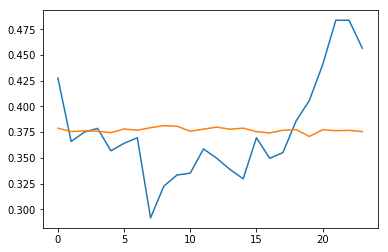

In [167]:
plt.figure()
plt.plot(range(24), [np.mean(events[events['serialpos']==sp]['recalled']) for sp in range(1,25)], color='C0', label='original')
plt.plot(range(24), [np.mean(resampled_events[resampled_events['serialpos']==sp]['recalled']) for sp in range(1,25)], color='C1', label='resampled')

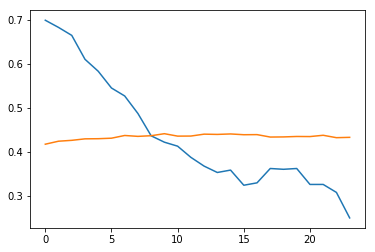

In [51]:
events, resampled_events = FR2_classifier_resample_nullauc('LTP357')

plt.figure()
plt.plot(range(24), [np.mean(events[events['serialpos']==sp]['recalled']) for sp in range(1,25)], color='C0', label='original')
plt.plot(range(24), [np.mean(resampled_events[resampled_events['serialpos']==sp]['recalled']) for sp in range(1,25)], color='C1', label='resampled')

In [ ]:
# on average, how much of all events were excluded in resampling?

In [244]:
resample_proportion = np.ones(len(FR2_valid_subjects))*np.nan
for i, s in enumerate(FR2_valid_subjects):
    files = glob.glob('scratch/mtpower/%s/%s_enc_enc_clsf_resample_run*_result.pkl'%(s,s))
    x = pkl.load(open(files[0],'rb'))
    resample_proportion[i] = len(x['train_events'])/len(x['test_events'])
print(np.mean(resample_proportion), np.std(resample_proportion))

0.7665936096873117 0.03945123377479124


In [252]:
resample_proportion = np.ones(len(FR2_valid_subjects))*np.nan
for i, s in enumerate(FR2_valid_subjects):
    files = glob.glob('scratch/mtpower/%s/%s_retci_retci_clsf_resample_run*_result.pkl'%(s,s))
    x = pkl.load(open(files[0],'rb'))
    resample_proportion[i] = len(x['train_events'])/len(x['test_events'])
print(np.mean(resample_proportion), np.std(resample_proportion))

0.5320779547259019 0.11052250399845381


In [330]:
def get_resampled_enc_pc(events):
    pc = []
    for sess in np.unique(events['session']):
        sess_events = events[events['session']==sess]
        sess_pc = [np.mean(sess_events[sess_events['serialpos']==i]['recalled']) for i in range(1,25)]
        pc.append(sess_pc)
    return np.nanmean(pc, 0)

def get_resampled_ret_pc(events):
    rectime_bins = np.arange(0, 75.1, 7.5)*1000
    pc = []
    for sess in np.unique(events['session']):
        sess_events = events[events['session']==sess]
        sess_pc = [np.mean(events[(events['rectime']>rectime_bins[b-1])&(events['rectime']<=rectime_bins[b])]['intrusion']==0) 
                     for b in range(1,11)]
        pc.append(sess_pc)
    return np.nanmean(pc, 0)

In [323]:
resample_spc = np.ones((len(FR2_valid_subjects),24))*np.nan
for i, s in enumerate(FR2_valid_subjects):
    f = 'scratch/mtpower/%s/%s_enc_enc_clsf_resample_run1_result.pkl'%(s,s)
    x = pkl.load(open(f,'rb'))['train_events']
    resample_spc[i] = get_resampled_enc_pc(x)

(0.4, 0.6)

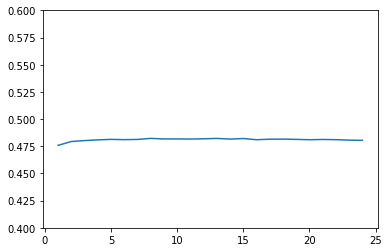

In [335]:
plt.figure()
plt.plot(range(1,25), np.mean(resample_spc,0))
plt.ylim([0.4,0.6])

In [332]:
resample_rpc = np.ones((len(FR2_valid_subjects),10))*np.nan
for i, s in enumerate(FR2_valid_subjects):
    f = 'scratch/mtpower/%s/%s_retci_retci_clsf_resample_run1_result.pkl'%(s,s)
    x = pkl.load(open(f,'rb'))['train_events']
    resample_rpc[i] = get_resampled_ret_pc(x)

(0.9, 1)

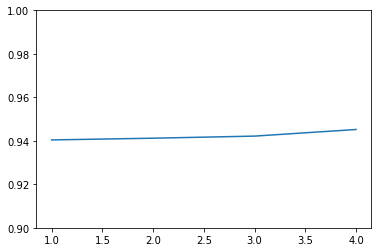

In [334]:
plt.figure()
plt.plot(range(1,11), np.mean(resample_rpc,0))
plt.ylim([0.9,1])

#### check performance

In [253]:
# concat auc across all

phase = 'retci'
n_run = 20

aucs = np.ones((len(FR2_valid_subjects), n_run))*np.nan
for i, subject in enumerate(FR2_valid_subjects):
    print(subject, end=',')
    files = glob.glob('scratch/mtpower/%s/%s_%s_%s_clsf_resample_run*_result.pkl' % (subject, subject, phase, phase))
    aucs[i] = [pkl.load(open(f, 'rb'))['auc'] for f in files]

aucs = np.array(aucs)
# np.save('scratch/mtpower/%s_%s_resample_auc.npy'%(phase,phase), aucs)

LTP093,LTP106,LTP115,LTP117,LTP123,LTP133,LTP138,LTP207,LTP210,LTP228,LTP229,LTP236,LTP246,LTP249,LTP250,LTP251,LTP258,LTP259,LTP265,LTP269,LTP273,LTP278,LTP279,LTP280,LTP283,LTP285,LTP287,LTP293,LTP296,LTP297,LTP299,LTP301,LTP302,LTP303,LTP304,LTP305,LTP306,LTP307,LTP310,LTP311,LTP312,LTP316,LTP317,LTP318,LTP321,LTP322,LTP323,LTP324,LTP325,LTP326,LTP327,LTP328,LTP329,LTP331,LTP334,LTP336,LTP339,LTP341,LTP342,LTP343,LTP344,LTP346,LTP347,LTP348,LTP349,LTP354,LTP355,LTP357,LTP360,LTP361,LTP362,LTP364,LTP365,LTP366,LTP367,LTP371,LTP372,LTP373,LTP374,LTP376,LTP377,LTP385,LTP386,LTP387,LTP389,LTP390,LTP391,LTP393,

In [254]:
def test_resample_clsf_significance(trainphase, testphase):
    
    def binomial_test(pvals, alpha=0.05):
        count = (pvals < alpha).sum()
        group_p = sp.stats.binom_test(count, len(pvals), 0.05, alternative='greater')
        return group_p
    
    subjects = FR2_valid_subjects
    print('Evaluating FR2 classifier performance for %d subjects...' % (len(subjects)))
    print('    Train phase: %s    Test phase: %s' % (trainphase, testphase))
    
    true_aucs = np.load('scratch/mtpower/%s_%s_resample_auc.npy'%(trainphase, testphase))
    true_aucs = np.mean(true_aucs, 1) # mean over all 20 resample runs
    print('    Mean AUC:', '%.2f'%np.mean(true_aucs), '  +-SE:', sp.stats.sem(true_aucs))
    
    null_aucs = np.array([np.load('scratch/mtpower/%s/%s_%s_%s_resample_null_aucs.npy'% (subject, subject, trainphase, testphase))
                          for subject in subjects])
    
    pvals = np.array([ (null_aucs[i]>true_aucs[i]).sum()/float(len(null_aucs)) for i in range(len(true_aucs))])
    all_alpha = [0.01, 0.05]
    counts = []
    
    for alpha in all_alpha:
        count = (pvals < alpha).sum()
        counts.append(count)
    
    # remove overlaps 
    # - those who are significant at 0.001 are subtracted from 0.01 and 0.05
    # - those who are significant at 0.01 are subtracted from 0.05
    counts[1] = counts[1]-counts[0]
    
    for i, alpha in enumerate(all_alpha):
        print('    alpha=%.03f: \t %0.2f significant' % (alpha, counts[i]))
    
    print('    p<0.05: ', len(subjects[pvals<0.05])) # subjects[pvals<0.05])
    
    group_p = binomial_test(pvals)
    print('    group binomial test:  p=%.11f, %s' % (group_p, 'significant' if group_p<0.05 else'non significant'))
    group_t, group_p = scipy.stats.ttest_rel(true_aucs, null_aucs.mean(1))
    print('    group t-test: t=%f, p=%f, %s' % (group_t, group_p, 'significant' if group_p<0.05 else'non significant'))
    
    return (subjects[pvals<0.05], subjects[pvals>=0.05])

In [255]:
x = test_resample_clsf_significance('enc', 'enc')
x = test_resample_clsf_significance('retci', 'retci')

Evaluating FR2 classifier performance for 88 subjects...
    Train phase: enc    Test phase: enc
    Mean AUC: 0.59   +-SE: 0.003825460701743545
    alpha=0.010: 	 85.00 significant
    alpha=0.050: 	 2.00 significant
    p<0.05:  87
    group binomial test:  p=0.00000000000, significant
    group t-test: t=24.124153, p=0.000000, significant
Evaluating FR2 classifier performance for 88 subjects...
    Train phase: retci    Test phase: retci
    Mean AUC: 0.57   +-SE: 0.0062514149778344205
    alpha=0.010: 	 26.00 significant
    alpha=0.050: 	 22.00 significant
    p<0.05:  48
    group binomial test:  p=0.00000000000, significant
    group t-test: t=10.236359, p=0.000000, significant


In [258]:
def get_subject_ROC_resample(subject, trainphase, testphase):
    
    files = glob.glob('scratch/mtpower/%s/%s_%s_%s_clsf_resample_run*_result.pkl' % (subject,subject,trainphase,testphase))
    roc_subj = np.ones((len(files), 200))*np.nan
    for i, f in enumerate(files):
        x = pkl.load(open(f,'rb'))
        roc_subj[i] = compute_ROC_AUC(x['y'], x['yhat'], base=200)[0]
    return roc_subj.mean(0)

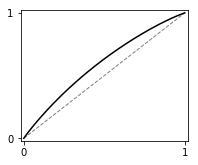

In [67]:
phase = 'enc'
roc_all = np.ones((len(FR2_valid_subjects),200))
for i, s in enumerate(FR2_valid_subjects):
    roc_all[i] = get_subject_ROC_resample(s, phase, phase)

fig, ax = plt.subplots(1, 1,figsize=[3, 2.4])
plot_ROC(ax, roc=roc_all.mean(0))
# fig.savefig('figures_final/clsf_resample_%s.pdf'%phase)

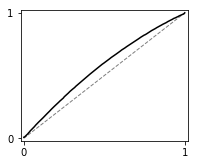

In [259]:
phase = 'retci'
roc_all = np.ones((len(FR2_valid_subjects),200))
for i, s in enumerate(FR2_valid_subjects):
    roc_all[i] = get_subject_ROC_resample(s, phase, phase)

fig, ax = plt.subplots(1, 1,figsize=[3, 2.4])
plot_ROC(ax, roc=roc_all.mean(0))
# fig.savefig('figures_final/clsf_resample_%s.pdf'%phase)

In [260]:
# fig.savefig('figures_final/clsf_resample_%s.pdf'%phase)

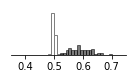

In [20]:
phase = 'enc'
observed_aucs = np.load('scratch/mtpower/%s_%s_resample_auc.npy'%(phase, phase)).mean(1) # mean over runs
null_aucs = np.array([np.load('scratch/mtpower/%s/%s_%s_%s_resample_null_aucs.npy'%(s,s,phase,phase)).mean()
                      for s in FR2_valid_subjects])
fig, ax = plot_auc_null(observed_aucs, null_aucs)
# fig.savefig('figures_final/clsf_resample_%s_aucnull.pdf'%phase, transparent=True)

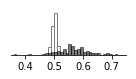

In [262]:
phase = 'retci'
observed_aucs = np.load('scratch/mtpower/%s_%s_resample_auc.npy'%(phase, phase)).mean(1) # mean over runs
null_aucs = np.array([np.load('scratch/mtpower/%s/%s_%s_%s_resample_null_aucs.npy'%(s,s,phase,phase)).mean()
                      for s in FR2_valid_subjects])
fig, ax = plot_auc_null(observed_aucs, null_aucs)
# fig.savefig('figures_final/clsf_resample_%s_aucnull.pdf'%phase, transparent=True)

In [79]:
phase = 'enc'
sig_subjects = test_resample_clsf_significance(phase, phase)[0] # subjects whose classifier is significant with p<0.05

result = []
for subject in sig_subjects:
    files = glob.glob('scratch/mtpower/%s/%s_%s_%s_clsf_resample_run*_result.pkl' % (subject, subject, phase, phase))
    values = [pkl.load(open(f, 'rb'))['avgA'] for f in files]
    values = xr.concat(values, dim='run').mean('run')
    values = split_ROIs(values, sys=get_eeg_sys(subject))
    result.append(values)

Evaluating FR2 classifier performance for 88 subjects...
    Train phase: enc    Test phase: enc
    Mean AUC: 0.59   +-SE: 0.003825460701743545
    alpha=0.010: 	 85.00 significant
    alpha=0.050: 	 2.00 significant
    p<0.05:  87
    group binomial test:  p=0.00000000000, significant
    group t-test: t=24.124153, p=0.000000, significant


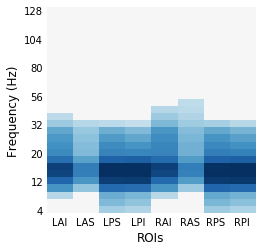

In [82]:
# encoding
fig, ax = plot_heatmap_contrast(result, vmin=-1.2, vmax=1.2, colorbar=False, figsize=[4.2,3.6])
# fig.savefig('figures_final/clsf_resample_atv_%s.pdf'%phase)

In [5]:
files = glob.glob('scratch/mtpower/%s/%s_%s_%s_clsf_resample_run*_result.pkl' % ('LTP093', 'LTP093', 'enc', 'enc'))

In [263]:
phase = 'retci'
sig_subjects = test_resample_clsf_significance(phase, phase)[0] # subjects whose classifier is significant with p<0.05

result = []
for subject in sig_subjects:
    files = glob.glob('scratch/mtpower/%s/%s_%s_%s_clsf_resample_run*_result.pkl' % (subject, subject, phase, phase))
    values = [pkl.load(open(f, 'rb'))['avgA'] for f in files]
    values = xr.concat(values, dim='run').mean('run')
    values = split_ROIs(values, sys=get_eeg_sys(subject))
    result.append(values)

Evaluating FR2 classifier performance for 88 subjects...
    Train phase: retci    Test phase: retci
    Mean AUC: 0.57   +-SE: 0.0062514149778344205
    alpha=0.010: 	 26.00 significant
    alpha=0.050: 	 22.00 significant
    p<0.05:  48
    group binomial test:  p=0.00000000000, significant
    group t-test: t=10.236359, p=0.000000, significant


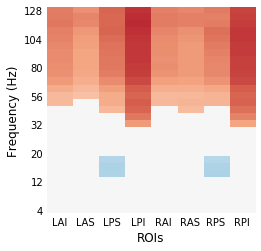

In [267]:
# retrieval
fig, ax = plot_heatmap_contrast(result, vmin=-1.2, vmax=1.2, colorbar=False, figsize=[4.2,3.6])
# fig.savefig('figures_final/clsf_resample_atv_%s.pdf'%phase)

### re-plot example subjects and list output

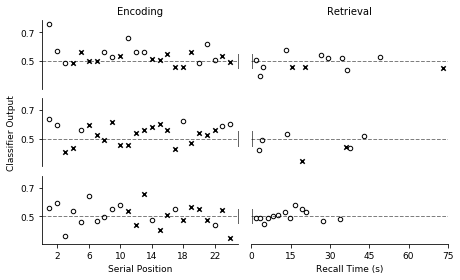

In [2]:
example_subjects = ['LTP366', 'LTP354', 'LTP207']
from plot_utils import plot_example_lists
lists = [['LTP366', 12, 24],
         ['LTP354', 3, 23],
         ['LTP207', 2, 21]]
fig, axes = plot_example_lists(lists, resample=True, figsize=[6.5,4])

In [3]:
# fig.savefig('figures_final/examplelist_resample.pdf')

In [47]:
def get_subject_ROC(subject, trainphase, testphase):
    
    files = glob.glob('scratch/mtpower/%s/%s_%s_%s_clsf_resample_run*_result.pkl'%(subject, subject, trainphase, testphase))
    rocs = []
    aucs = []
    for f in files:
        resultpack = pkl.load(open(f,'rb'))
        y = resultpack['y']
        yhat = resultpack['yhat']
        roc, aucscore = compute_ROC_AUC(y, yhat, base=200)
        rocs.append(roc)
        aucs.append(aucscore)
    roc = np.mean(rocs, 0)

    return roc, np.mean(aucs)

def get_classifier_pval_1subj(subject, trainphase, testphase):
    aucs = np.load('scratch/mtpower/%s_%s_resample_auc.npy'%(trainphase, testphase)).mean(1)
    aucscore = aucs[FR2_valid_subjects.tolist().index(subject)]
    f = 'scratch/mtpower/%s/%s_%s_%s_resample_null_aucs.npy' % (subject, subject, trainphase, testphase)
    null_aucs = np.load(f)

    return np.sum(null_aucs>aucscore)/len(null_aucs)

In [54]:
get_classifier_pval_1subj(example_subjects[3-1], 'retci', 'retci')

0.26

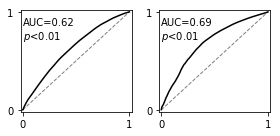

In [57]:
# Example ROC plot
subj_ind = 2
s = example_subjects[subj_ind-1]

fig, axes = plt.subplots(1,2,figsize=[4,2])

subj_ROC, subj_auc = get_subject_ROC(s, 'enc', 'enc')
plot_ROC(axes[0], roc=subj_ROC, text='AUC=%.2f\n'%subj_auc+r'$\it{p}$'+'<0.01')

subj_ROC, subj_auc = get_subject_ROC(s, 'retci', 'retci')
plot_ROC(axes[1], roc=subj_ROC, text='AUC=%.2f\n'%subj_auc+r'$\it{p}$'+'<0.01') # p=0.26 for subj_ind=3

fig.tight_layout(h_pad=0)

In [58]:
# fig.savefig('figures_final/s%d_rocauc_resample.pdf'%subj_ind)

In [11]:
def plot_auc_null_1subj(observed_auc, null_aucs):
    fig, ax = plt.subplots(1, 1, figsize=[2,1.2])
    ax.axvline(observed_auc, ymax=0.8, color='k')
    ax.hist(null_aucs, color='w', edgecolor='gray', bins=np.arange(0.35,0.75,0.01))
    ax.set_xlim([0.34, 0.75])
    ax.set_xticks([0.4,0.5,0.6,0.7])
    ax.set_ylim([0, 25])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.tight_layout()
    return fig, ax

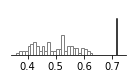

In [18]:
subj_ind = 1
s = example_subjects[subj_ind-1]
phase = 'retci'
observed_auc = get_subject_ROC(s, phase, phase)[1]
null_aucs = np.load('scratch/mtpower/%s/%s_%s_%s_resample_null_aucs.npy'%(s,s,phase,phase))
fig, ax = plot_auc_null_1subj(observed_auc, null_aucs)

# fig.savefig('figures_final/s%d_%s_aucnull_resample.pdf'%(subj_ind, phase),
#              transparent=True, bbox_inches="tight")

#### check classifier output per clutser type & time

In [268]:
labeled_events = pkl.load(open('FR2_all_events_clustered.pkl','rb'))
enc_labeled_events = labeled_events[labeled_events['type']=='WORD']
ret_labeled_events = labeled_events[labeled_events['type']=='REC_WORD']

encoding list dynamics

In [582]:
enc_sig_subjects = test_resample_clsf_significance('enc', 'enc')[0]

Evaluating FR2 classifier performance for 88 subjects...
    Train phase: enc    Test phase: enc
    Mean AUC: 0.59   +-SE: 0.003825460701743545
    alpha=0.010: 	 85.00 significant
    alpha=0.050: 	 2.00 significant
    p<0.05:  87
    group binomial test:  p=0.00000000000, significant
    group t-test: t=24.124153, p=0.000000, significant


In [583]:
encresults = []
for subject in enc_sig_subjects:
    print(subject, end=',')
    files = glob.glob('scratch/mtpower/%s/%s_enc_enc_clsf_resample_run*_result.pkl'%(subject,subject))
    encresults.append([pkl.load(open(f,'rb')) for f in files])

LTP093,LTP106,LTP115,LTP117,LTP123,LTP133,LTP138,LTP207,LTP210,LTP228,LTP229,LTP236,LTP246,LTP249,LTP250,LTP251,LTP258,LTP259,LTP265,LTP269,LTP273,LTP278,LTP279,LTP280,LTP283,LTP285,LTP287,LTP293,LTP296,LTP297,LTP299,LTP301,LTP302,LTP303,LTP304,LTP305,LTP306,LTP307,LTP310,LTP311,LTP312,LTP316,LTP317,LTP318,LTP321,LTP322,LTP323,LTP324,LTP325,LTP326,LTP327,LTP328,LTP329,LTP331,LTP334,LTP336,LTP339,LTP341,LTP342,LTP343,LTP344,LTP346,LTP347,LTP348,LTP349,LTP354,LTP355,LTP357,LTP360,LTP361,LTP362,LTP364,LTP365,LTP366,LTP367,LTP371,LTP372,LTP373,LTP374,LTP376,LTP377,LTP385,LTP386,LTP387,LTP390,LTP391,LTP393,

In [92]:
# encoding output by clustering type and serial position - data 
BCall = []
TCall = []
SCall = []
NCall = []
NRall = []
for i, subject in enumerate(enc_sig_subjects):
    print(subject, end=',')
    
    def get_cluster_type(select_events, all_events):
        subject_data = all_events[all_events['subject']==subject]
        subject_data = subject_data.sort_values('mstime')
        events_index = np.in1d(subject_data['mstime'].values, select_events['mstime'])
        return subject_data['cluster_type'][events_index]
    
    def mean_yhat(all_yhat, events):
        result = []
        for sess in np.unique(events['session']):
            # if clean data: some sessions are missing items
            if subject == 'LTP246' and sess == 6: # LTP246 sess 6 trial 4 has only one item
                sess_index = (events['session']==sess) & (events['trial']!=4)
            elif subject == 'LTP258' and sess == 17: # LTP258 sess 17 trial 1 has only 14 items
                sess_index = (events['session']==sess) & (events['trial']!=1)
            else:
                sess_index = events['session']==sess
            n_list = len(np.unique(events[sess_index]['trial']))
            yhat = all_yhat[sess_index].reshape(n_list, 24)
            result.append(np.nanmean(yhat, 0))
        return np.nanmean(result, 0)
    
    def extract_one_type(yhat, events, conditions, ctype):
        x = yhat.copy()
        x[conditions!=ctype] = np.nan
        x = mean_yhat(x, events)
        return x
    
    subj_results = encresults[i]
    subj_BC = []
    subj_TC = []
    subj_SC = []
    subj_NC = []
    subj_NR = []
    for x in subj_results: # prediction from one run of resample classifier
        
        yhat = x['yhat']
        events = x['test_events']
        conditions = get_cluster_type(events, enc_labeled_events)
        subj_BC.append(extract_one_type(yhat, events, conditions, 'BC'))
        subj_TC.append(extract_one_type(yhat, events, conditions, 'TC'))
        subj_SC.append(extract_one_type(yhat, events, conditions, 'SC'))
        subj_NC.append(extract_one_type(yhat, events, conditions, 'NC'))
        subj_NR.append(extract_one_type(yhat, events, conditions, 'NR'))
    
    BCall.append(np.nanmean(np.array(subj_BC), 0)) # take mean over subject runs
    TCall.append(np.nanmean(np.array(subj_TC), 0))
    SCall.append(np.nanmean(np.array(subj_SC), 0))
    NCall.append(np.nanmean(np.array(subj_NC), 0))
    NRall.append(np.nanmean(np.array(subj_NR), 0))

BCall = np.array(BCall)
TCall = np.array(TCall)
SCall = np.array(SCall)
NCall = np.array(NCall)
NRall = np.array(NRall)

LTP093,LTP106,LTP115,LTP117,LTP123,LTP133,LTP138,LTP207,LTP210,LTP228,LTP229,LTP236,LTP246,LTP249,LTP250,LTP251,LTP258,LTP259,LTP265,LTP269,LTP273,LTP278,LTP279,LTP280,LTP283,LTP285,LTP287,LTP293,LTP296,LTP297,LTP299,LTP301,LTP302,LTP303,LTP304,LTP305,LTP306,LTP307,LTP310,LTP311,LTP312,LTP316,LTP317,LTP318,LTP321,LTP322,LTP323,LTP324,LTP325,LTP326,LTP327,LTP328,LTP329,LTP331,LTP334,LTP336,LTP339,LTP341,LTP342,LTP343,LTP344,LTP346,LTP347,LTP348,LTP349,LTP354,LTP355,LTP357,LTP360,LTP361,LTP362,LTP364,LTP365,LTP366,LTP367,LTP371,LTP372,LTP373,LTP374,LTP376,LTP377,LTP385,LTP386,LTP387,LTP390,LTP391,LTP393,

In [93]:
x = {'BCall':BCall, 'TCall':TCall, 'SCall':SCall, 'NCall':NCall, 'NRall':NRall}
# pkl.dump(x, open('data/clsf_resample_enc_output_ctypes.pkl','wb'))

In [283]:
x = pkl.load(open('data/clsf_resample_enc_output_ctypes.pkl','rb'))
BCall = x['BCall']
TCall = x['TCall']
SCall = x['SCall']
NCall = x['NCall']
NRall = x['NRall']

Text(11.75, 0.5, 'Classifier Output')

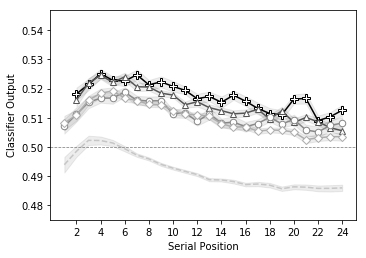

In [24]:
from plot_utils import plot_list_dynamics

values = [BCall, TCall, SCall, NCall, NRall]
labels=['BC','TC','SC','NC','NR']
colors=['k','#555555','#888888','#adadad','#c6c6c6']
markers=['P','^','o','D','']
markersizes=[7.5,6.5,6.5,5.5,0]
linestyles=['-','-','-','-','--']
xticks=np.arange(24)
jitters=[0]*len(values)

value_dict = {}
for i, label in enumerate(labels):
    value_dict[label] = {'value':values[i], 'color':colors[i], 'linestyle':linestyles[i],
                         'marker':markers[i], 'markersize':markersizes[i],
                         'xticks':xticks, 'jitter':jitters[i]}

fig, ax = plot_list_dynamics(value_dict)

ax.set_ylim([0.50,0.54])
ax.set_ylabel('Encoding Classifier Output')

ax.axhline(y=0.5, ls='--', lw=0.75, color='gray')

ax.set_xticks(range(24)[1::2])
ax.set_xticklabels(np.arange(1,25,1)[1::2])
ax.set_ylim([0.475,0.547])
ax.set_xlabel('Serial Position')
ax.set_ylabel('Classifier Output')

In [25]:
# fig.savefig('figures_final/yhat_resample_enc.pdf', bbox_inches="tight")

In [287]:
# mixed model data
data = pd.DataFrame(pd.Series(enc_sig_subjects,name='subject'))

data['BC_early'] = np.nanmean(BCall[:, :4], axis=1)
data['BC_mid'] = np.nanmean(BCall[:, 4:-4], axis=1)
data['BC_late'] = np.nanmean(BCall[:, -4:], axis=1)

data['TC_early'] = np.nanmean(TCall[:, :4], axis=1)
data['TC_mid'] = np.nanmean(TCall[:, 4:-4], axis=1)
data['TC_late'] = np.nanmean(TCall[:, -4:], axis=1)

data['SC_early'] = np.nanmean(SCall[:, :4], axis=1)
data['SC_mid'] = np.nanmean(SCall[:, 4:-4], axis=1)
data['SC_late'] = np.nanmean(SCall[:, -4:], axis=1)

data['NC_early'] = np.nanmean(NCall[:, :4], axis=1)
data['NC_mid'] = np.nanmean(NCall[:, 4:-4], axis=1)
data['NC_late'] = np.nanmean(NCall[:, -4:], axis=1)

data['NR_early'] = np.nanmean(NRall[:, :4], axis=1)
data['NR_mid'] = np.nanmean(NRall[:, 4:-4], axis=1)
data['NR_late'] = np.nanmean(NRall[:, -4:], axis=1)

In [288]:
data.head()

,subject,BC_early,BC_mid,BC_late,TC_early,TC_mid,TC_late,SC_early,SC_mid,SC_late,NC_early,NC_mid,NC_late,NR_early,NR_mid,NR_late
0,LTP093,0.508537,0.513756,0.505778,0.511679,0.516473,0.502734,0.493748,0.513514,0.513912,0.510450,0.507046,0.494553,0.498963,0.496239,0.489883
1,LTP106,0.510082,0.509941,0.495745,0.510400,0.504625,0.494062,0.508939,0.502228,0.509723,0.507620,0.504792,0.497459,0.495136,0.488898,0.481358
2,LTP115,0.521981,0.508946,0.505768,0.514384,0.503160,0.499304,0.508862,0.502348,0.496635,0.504565,0.500725,0.498229,0.491203,0.496454,0.490810
3,LTP117,0.511881,0.516900,0.492819,0.502839,0.511540,0.491754,0.489840,0.508362,0.506383,0.487280,0.507271,0.493554,0.482571,0.496550,0.487152
4,LTP123,0.507378,0.513508,0.504796,0.509357,0.508684,0.501771,0.504100,0.501796,0.497285,0.510393,0.502307,0.496740,0.499792,0.495448,0.491708


In [289]:
df = []
for subject in np.unique(data['subject']):
    yhat = data[data['subject']==subject].values[:,1:].T # first item is subject name
    x = pd.DataFrame(data=yhat, columns=['yhat'])
    x['subject'] = [subject] * len(yhat)
    x['event_type'] = np.repeat(['BC','TC','SC','NC','NR'], 3)
    x['listpos'] = np.tile(['early','mid','late'], 5)
    df.append(x)
df = pd.concat(df)

In [291]:
# df.to_csv('data/enc_yhat_resampled.csv')

retrieval dynamics

In [293]:
ret_sig_subjects = test_resample_clsf_significance('retci', 'retci')[0]

Evaluating FR2 classifier performance for 88 subjects...
    Train phase: retci    Test phase: retci
    Mean AUC: 0.57   +-SE: 0.0062514149778344205
    alpha=0.010: 	 26.00 significant
    alpha=0.050: 	 22.00 significant
    p<0.05:  48
    group binomial test:  p=0.00000000000, significant
    group t-test: t=10.236359, p=0.000000, significant


In [271]:
retresults = []
for subject in ret_sig_subjects:
    print(subject, end=',')
    files = glob.glob('scratch/mtpower/%s/%s_retci_retci_clsf_resample_run*_result.pkl'%(subject,subject))
    retresults.append([pkl.load(open(f,'rb')) for f in files])

LTP093,LTP115,LTP117,LTP123,LTP133,LTP138,LTP229,LTP250,LTP251,LTP259,LTP273,LTP280,LTP285,LTP297,LTP301,LTP304,LTP306,LTP310,LTP312,LTP316,LTP317,LTP318,LTP322,LTP323,LTP326,LTP329,LTP334,LTP336,LTP341,LTP343,LTP346,LTP347,LTP348,LTP349,LTP354,LTP357,LTP361,LTP364,LTP365,LTP366,LTP367,LTP373,LTP377,LTP385,LTP387,LTP389,LTP390,LTP393,

In [272]:
# retrieval output by clustering type and recall time - data 

CRall = []
BCall = []
TCall = []
SCall = []
NCall = []
INall = []
PIall = []
EIall = []

for i, subject in enumerate(ret_sig_subjects):
    print(subject, end=',')
    
    def get_cluster_type(select_events, all_events):
        subject_data = all_events[all_events['subject']==subject]
        subject_data = subject_data.sort_values('mstime')
        events_index = np.in1d(subject_data['mstime'].values, select_events['mstime'])
        return subject_data['cluster_type'][events_index]
    
    def find_bins(t, bins=np.arange(0, 75.1, 7.5)):
        return np.where(t>bins)[0][-1]
    
    def bin_trial(trial_yhat, bins):
        result = []
        for b in range(10):
            if b not in bins: # no recall in that bin
                result.append(np.nan)
            else:
                result.append(np.nanmean(trial_yhat[bins==b]))
        return np.array(result)
    
    def bin_session(sess_yhat, trial, bins):
        result = []
        for t in np.unique(trial):
            index = trial==t
            trial_result = bin_trial(sess_yhat[index], bins[index])
            result.append(trial_result)
        result = np.array(result)
        return np.nanmean(result,0)
    
    def extract_one_type(yhat, events, conditions, ctype, bins):
        x = yhat.copy()
        if ctype=='CR':
            x[events['intrusion']!=0] = np.nan
        elif ctype=='IN':
            x[events['intrusion']==0] = np.nan
        elif ctype=='PI':
            x[events['intrusion']<=0] = np.nan
        elif ctype=='EI':
            x[events['intrusion']>=0] = np.nan
        else:
            x[conditions!=ctype] = np.nan
        session = events['session']
        trial = events['trial']
        binned_x = []
        for sess in np.unique(session):
            index = session==sess
            sess_x = bin_session(x[index], trial[index], bins[index])
            binned_x.append(sess_x)
        return np.nanmean(binned_x,0)
    
    subj_results = retresults[i]
    subj_CR = []
    subj_BC = []
    subj_TC = []
    subj_SC = []
    subj_NC = []
    subj_IN = []
    subj_PI = []
    subj_EI = []
    
    for x in subj_results:

        # correct and incorrect
        yhat = x['yhat']
        events = x['test_events']
        conditions = get_cluster_type(events, ret_labeled_events)

        session = events['session']
        trial = events['trial']
        bins = np.array([find_bins(t/1000.0) for t in events['rectime']])
        
        subj_CR.append(extract_one_type(yhat, events, conditions, 'CR', bins))
        subj_BC.append(extract_one_type(yhat, events, conditions, 'BC', bins))
        subj_TC.append(extract_one_type(yhat, events, conditions, 'TC', bins))
        subj_SC.append(extract_one_type(yhat, events, conditions, 'SC', bins))
        subj_NC.append(extract_one_type(yhat, events, conditions, 'NC', bins))
        subj_IN.append(extract_one_type(yhat, events, conditions, 'IN', bins))
        subj_PI.append(extract_one_type(yhat, events, conditions, 'PI', bins))
        subj_EI.append(extract_one_type(yhat, events, conditions, 'EI', bins))
    
    CRall.append(np.nanmean(subj_CR,0))# take mean over subject runs
    BCall.append(np.nanmean(subj_BC,0))
    TCall.append(np.nanmean(subj_TC,0))
    SCall.append(np.nanmean(subj_SC,0))
    NCall.append(np.nanmean(subj_NC,0))
    INall.append(np.nanmean(subj_IN,0))
    PIall.append(np.nanmean(subj_PI,0))
    EIall.append(np.nanmean(subj_EI,0))
    
CRall = np.array(CRall)
INall = np.array(INall)
PIall = np.array(PIall)
EIall = np.array(EIall)
BCall = np.array(BCall)
TCall = np.array(TCall)
SCall = np.array(SCall)
NCall = np.array(NCall)

LTP093,LTP115,LTP117,LTP123,LTP133,LTP138,LTP229,LTP250,LTP251,LTP259,LTP273,LTP280,LTP285,LTP297,LTP301,LTP304,LTP306,LTP310,LTP312,LTP316,LTP317,LTP318,LTP322,LTP323,LTP326,LTP329,LTP334,LTP336,LTP341,LTP343,LTP346,LTP347,LTP348,LTP349,LTP354,LTP357,LTP361,LTP364,LTP365,LTP366,LTP367,LTP373,LTP377,LTP385,LTP387,LTP389,LTP390,LTP393,

In [281]:
# saving them cuz they take so long to run...
x = {'CRall':CRall, 'INall':INall, 'PIall':PIall, 'EIall':EIall,
     'BCall':BCall, 'TCall':TCall, 'SCall':SCall, 'NCall':NCall}
# pkl.dump(x, open('data/resample_clsf_retci_output_ctypes.pkl','wb'))

In [292]:
x = pkl.load(open('data/resample_clsf_retci_output_ctypes.pkl','rb'))
CRall = x['CRall']
BCall = x['BCall']
TCall = x['TCall']
SCall = x['SCall']
NCall = x['NCall']
INall = x['INall']
PIall = x['PIall']
EIall = x['EIall']

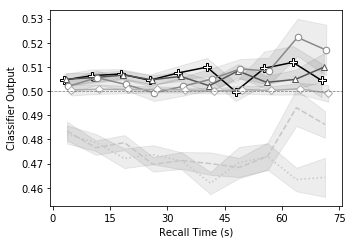

In [279]:
from plot_utils import plot_list_dynamics

values = [BCall, TCall, SCall, NCall, PIall, EIall]
labels=['BC','TC','SC','NC','PLI','ELI']
colors=['k','#555555','#888888','#adadad','#c6c6c6','#c6c6c6']
markers=['P','^','o','D','','']
markersizes=[7.5,6.5,6.5,5.5,0,0]
linestyles=['-','-','-','-','--',':']
xticks = np.arange(7.5, 75.1, 7.5)-7.5/2
jitters = [-0.9,-0.3,0.3,0.9,0,0]

value_dict = {}
for i, label in enumerate(labels):
    value_dict[label] = {'value':values[i], 'color':colors[i], 'linestyle':linestyles[i],
                         'marker':markers[i], 'markersize':markersizes[i],
                         'xticks':xticks, 'jitter':jitters[i]}

fig, ax = plot_list_dynamics(value_dict)

ax.axhline(0.5, ls='--', lw=0.75, color='gray')
# ax.set_ylim([0.43,0.524])
ax.set_xticks(np.arange(0,76,15))
ax.set_xticklabels(np.arange(0,76,15))
ax.set_xlabel('Recall Time (s)')
ax.set_ylabel('Classifier Output')

# ax.legend(loc=3, fontsize='medium')
fig.tight_layout()

In [280]:
# fig.savefig('figures_final/yhat_resample_retci.pdf', bbox_inches="tight")

In [295]:
# mixed model data
retdata = pd.DataFrame(pd.Series(ret_sig_subjects, name='subject'))

retdata['BC_early'] = np.nanmean(BCall[:, :3], axis=1)
retdata['BC_mid'] = np.nanmean(BCall[:, 3:-3], axis=1)
retdata['BC_late'] = np.nanmean(BCall[:, -3:], axis=1)

retdata['TC_early'] = np.nanmean(TCall[:, :3], axis=1)
retdata['TC_mid'] = np.nanmean(TCall[:, 3:-3], axis=1)
retdata['TC_late'] = np.nanmean(TCall[:, -3:], axis=1)

retdata['SC_early'] = np.nanmean(SCall[:, :3], axis=1)
retdata['SC_mid'] = np.nanmean(SCall[:, 3:-3], axis=1)
retdata['SC_late'] = np.nanmean(SCall[:, -3:], axis=1)

retdata['NC_early'] = np.nanmean(NCall[:, :3], axis=1)
retdata['NC_mid'] = np.nanmean(NCall[:, 3:-3], axis=1)
retdata['NC_late'] = np.nanmean(NCall[:, -3:], axis=1)

retdata['IN_early'] = np.nanmean(INall[:, :3], axis=1)
retdata['IN_mid'] = np.nanmean(INall[:, 3:-3], axis=1)
retdata['IN_late'] = np.nanmean(INall[:, -3:], axis=1)

retdata['PI_early'] = np.nanmean(PIall[:, :3], axis=1)
retdata['PI_mid'] = np.nanmean(PIall[:, 3:-3], axis=1)
retdata['PI_late'] = np.nanmean(PIall[:, -3:], axis=1)

retdata['EI_early'] = np.nanmean(EIall[:, :3], axis=1)
retdata['EI_mid'] = np.nanmean(EIall[:, 3:-3], axis=1)
retdata['EI_late'] = np.nanmean(EIall[:, -3:], axis=1)

In [296]:
retdata.head()

,subject,BC_early,BC_mid,BC_late,TC_early,TC_mid,TC_late,SC_early,SC_mid,SC_late,...,NC_late,IN_early,IN_mid,IN_late,PI_early,PI_mid,PI_late,EI_early,EI_mid,EI_late
0,LTP093,0.503249,0.484918,0.504150,0.499701,0.512255,0.520202,0.490581,0.508631,0.571349,...,0.505192,0.485790,0.492090,0.499440,0.476994,0.517342,0.513853,0.482603,0.463798,0.470614
1,LTP115,0.510398,0.493948,0.474923,0.507648,0.492662,0.495997,0.501712,0.496576,0.486097,...,0.485726,0.492302,0.467879,0.462695,0.485273,0.464213,0.446148,0.499472,0.472526,0.457378
2,LTP117,0.512361,0.523450,0.526046,0.501467,0.512099,0.531083,0.496272,0.504592,0.560695,...,0.520025,0.476040,0.476225,0.495930,0.472822,0.488655,0.508901,0.483552,0.474700,0.483019
3,LTP123,0.514387,0.505209,0.499681,0.514422,0.499530,0.488297,0.512978,0.503496,0.487804,...,0.490595,0.487947,0.472701,0.461123,0.482527,0.472430,0.462460,0.492545,0.475120,0.451347
4,LTP133,0.512787,0.502694,0.490914,0.504298,0.501351,0.505832,0.506713,0.518210,0.560180,...,0.498602,0.480540,0.454713,0.474685,0.486743,0.446622,0.475050,0.462505,0.470971,0.482183


In [297]:
df = []
for subject in np.unique(retdata['subject']):
    yhat = retdata[retdata['subject']==subject].values[:,1:].T # first item is subject name
    x = pd.DataFrame(data=yhat, columns=['yhat'])
    x['subject'] = [subject] * len(yhat)
    x['event_type'] = np.repeat(['BC','TC','SC','NC','IN','PI','EI'], 3)
    x['listpos'] = np.tile(['early','mid','late'], 7)
    df.append(x)
df = pd.concat(df)

In [298]:
df.head()

,yhat,subject,event_type,listpos
0,0.503249,LTP093,BC,early
1,0.484918,LTP093,BC,mid
2,0.50415,LTP093,BC,late
3,0.499701,LTP093,TC,early
4,0.512255,LTP093,TC,mid


In [299]:
# df.to_csv('data/ret_yhat_resampled.csv')

#### check correlation with behavioral indexes

In [2]:
behavioral_scores = pkl.load(open('data/behvaioral_scores.pkl','rb'))
precs = np.array([x['prec'] for x in behavioral_scores])
primacy_factors = np.array([x['primacy'] for x in behavioral_scores])
temp_factors = np.array([x['temp'] for x in behavioral_scores])
sem_factors = np.array([x['sem'] for x in behavioral_scores])

In [584]:
# match encoding yhat with events
merged_yhat_events_all = []
for i, subject in enumerate(enc_sig_subjects):
    
    def get_recall_status(select_events, all_events):
        subject_data = all_events[all_events['subject']==subject]
        subject_data = subject_data.sort_values('mstime')
        events_index = np.in1d(subject_data['mstime'].values, select_events['mstime'])
        return subject_data[['subject','session','trial','serialpos','cluster_type']][events_index]
    
    yhat = np.mean([x['yhat'] for x in encresults[i]], 0) # across multiple resample runs
    events = encresults[i][0]['test_events'] # same test events for all runs
    matching_events = get_recall_status(events, enc_labeled_events)
    merged_yhat_events = pd.DataFrame(matching_events)
    merged_yhat_events['yhat'] = yhat
    merged_yhat_events_all.append(merged_yhat_events)

merged_yhat_events_all = pd.concat(merged_yhat_events_all)

In [585]:
aucs = []
tc_nc_t = []
sc_nc_t = []
early_middle_t = []
for i, s in enumerate(enc_sig_subjects):
    x = merged_yhat_events_all[merged_yhat_events_all['subject']==s]
    if s == 'LTP258':
        # trial missing serialpos 1-10
        x = x[~((x['session']==17)&(x['trial']==1))]
    
    aucs.append(np.mean([x['auc'] for x in encresults[i]]))
    # tc vs. nc
    t, p = sp.stats.ttest_ind(x['yhat'][x['cluster_type']=='TC'], 
                              x['yhat'][x['cluster_type']=='NC'])
    tc_nc_t.append(t)
    # sc vs. nc
    t, p = sp.stats.ttest_ind(x['yhat'][x['cluster_type']=='SC'], 
                              x['yhat'][x['cluster_type']=='NC'])
    sc_nc_t.append(t)
    # early vs. middle
    early = np.mean(np.array([x['yhat'][x['serialpos'].values==i] for i in range(1,5)]).T, 1)
    middle = np.mean(np.array([x['yhat'][x['serialpos'].values==i] for i in range(5,21)]).T, 1)
        
    t, p = sp.stats.ttest_ind(early, middle)
    early_middle_t.append(t)

In [586]:
enc_stats = pd.DataFrame(data=enc_sig_subjects, columns=['subject'])
enc_stats['prec'] = precs[np.in1d(FR2_valid_subjects, enc_sig_subjects)]
enc_stats['primacy_factors'] = primacy_factors[np.in1d(FR2_valid_subjects, enc_sig_subjects)]
enc_stats['temp_factors'] = temp_factors[np.in1d(FR2_valid_subjects, enc_sig_subjects)]
enc_stats['sem_factors'] = sem_factors[np.in1d(FR2_valid_subjects, enc_sig_subjects)]
enc_stats['auc'] = aucs
enc_stats['tc_nc_t'] = tc_nc_t
enc_stats['sc_nc_t'] = sc_nc_t
enc_stats['early_middle_t'] = early_middle_t

In [591]:
# pkl.dump(enc_stats, open('data/enc_corr_stats_resampled.pkl','wb'))

In [589]:
print(sp.stats.pearsonr(enc_stats['early_middle_t'], enc_stats['primacy_factors']))
print(sp.stats.pearsonr(enc_stats['tc_nc_t'], enc_stats['temp_factors']))
print(sp.stats.pearsonr(enc_stats['sc_nc_t'], enc_stats['sem_factors']))

(0.2064469173846324, 0.05505032634969271)
(0.3387846127747556, 0.00132851149781277)
(0.23716669372656232, 0.026979990841425883)


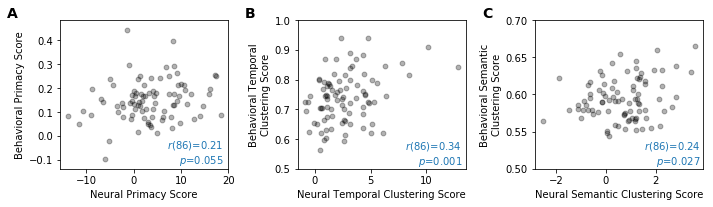

In [126]:
fig, axes = plt.subplots(1, 3, figsize=[10,3])

ax = axes[0]
ax.scatter(enc_stats['early_middle_t'], enc_stats['primacy_factors'], color='black', s=23, alpha=0.3)
ax.set_xlabel('Neural Primacy Score')
ax.set_ylabel('Behavioral Primacy Score')
ax.text(19, -0.072, r'$\it{r}$'+'(86)=0.21\n'+r'$\it{p}$=0.055', ha='right', va='center', color='C0')
ax.set_yticks(np.arange(-0.1, 0.41, 0.1))
ax.text(-0.25, 1.09, 'A', transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

ax = axes[1]
ax.scatter(enc_stats['tc_nc_t'], enc_stats['temp_factors'], color='black', s=23, alpha=0.3)
ax.set_xlabel('Neural Temporal Clustering Score')
ax.set_ylabel('Behavioral Temporal\nClustering Score')
ax.text(13.2, 0.55, r'$\it{r}$'+'(86)=0.34\n'+r'$\it{p}$=0.001', ha='right', va='center', color='C0')
ax.set_yticks(np.arange(0.5, 1.01, 0.1))
ax.text(-0.25, 1.09, 'B', transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

ax = axes[2]
axes[2].scatter(enc_stats['sc_nc_t'], enc_stats['sem_factors'], color='black', s=23, alpha=0.3)
ax.set_xlabel('Neural Semantic Clustering Score')
ax.set_ylabel('Behavioral Semantic\nClustering Score')
ax.text(3.8, 0.52, r'$\it{r}$'+'(86)=0.24\n'+r'$\it{p}$=0.027', ha='right', va='center', color='C0')
ax.set_yticks(np.arange(0.5, 0.71, 0.05))
ax.text(-0.25, 1.09, 'C', transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

fig.tight_layout()

In [127]:
# fig.savefig('figures_final/corr_resample.pdf')

#### test difference between correlations

In [3]:
enc_stats_reampled = pkl.load(open('data/enc_corr_stats_resampled.pkl','rb'))
enc_stats = pkl.load(open('data/enc_corr_stats.pkl','rb'))

In [4]:
print(sp.stats.pearsonr(enc_stats['early_middle_t'], enc_stats['primacy_factors']))
print(sp.stats.pearsonr(enc_stats['tc_nc_t'], enc_stats['temp_factors']))
print(sp.stats.pearsonr(enc_stats['sc_nc_t'], enc_stats['sem_factors']))

(0.5620240950416232, 1.2147660024130266e-08)
(0.20557733821526472, 0.054670015574951394)
(0.2003606341998443, 0.06124776374621015)


In [5]:
print(sp.stats.pearsonr(enc_stats_reampled['early_middle_t'], enc_stats_reampled['primacy_factors']))
print(sp.stats.pearsonr(enc_stats_reampled['tc_nc_t'], enc_stats_reampled['temp_factors']))
print(sp.stats.pearsonr(enc_stats_reampled['sc_nc_t'], enc_stats_reampled['sem_factors']))

(0.2064469173846324, 0.05505032634969271)
(0.3387846127747556, 0.00132851149781277)
(0.23716669372656232, 0.026979990841425883)


In [59]:
def boot_corr_test(x, y1, y2, n_test=1000):
    result = np.zeros(n_test)
    n = len(x)
    for i in range(n_test):
        samples = np.random.choice(list(range(n)), size=n, replace=True)
        cor1 = sp.stats.pearsonr(x[samples], y1[samples])[0]
        cor2 = sp.stats.pearsonr(x[samples], y2[samples])[0]
        result[i] = cor1-cor2
    result = np.sort(result)
    CI = [result[24], result[-25]]
    return result, np.mean(result), CI

In [55]:
boot_corr_test(x = enc_stats_reampled['primacy_factors'], 
               y1 = enc_stats['early_middle_t'],
               y2 = enc_stats_reampled['early_middle_t'],
               n_test=1000)

(0.3075080784031517, [0.1554525110533475, 0.4568611748546187])

In [56]:
boot_corr_test(x = enc_stats_reampled['temp_factors'], 
               y1 = enc_stats['tc_nc_t'],
               y2 = enc_stats_reampled['tc_nc_t'],
               n_test=1000)

(-0.07749047655719636, [-0.19294964382075286, 0.04849788406973421])

In [57]:
boot_corr_test(x = enc_stats_reampled['sem_factors'], 
               y1 = enc_stats['sc_nc_t'],
               y2 = enc_stats_reampled['sc_nc_t'],
               n_test=1000)

(-0.06585436732636844, [-0.1611995072990193, 0.021070607226487292])

### null-classifiers by shuffling within session x serialpos

In [ ]:
def FR2_classifier_shuffle_session_serialpos_nullauc(subject):
    
    # global flags
    train_phase = 'ret'
    test_phase = 'ret'
    ret_type = ['ci', 'cp', 'ce', 'pe'][0] # 'correct vs. incorrect', 'correct vs. pli', 'correct vs. eli', 'pli vs. eli'
    n_tests = 100
    
    train_label = 'recalled' if train_phase=='enc' else 'rec_label'
    test_label = 'recalled' if test_phase=='enc' else 'rec_label'
    
    import pickle as pkl
    import numpy as np
    import pandas as pd
    import xarray as xr
    from sklearn.metrics import roc_auc_score
    
    from constants import best_C
    from utils import load_feature, divide_folds, compute_activation, \
                      leave_one_session_out_forward_model
    
    def shuffle_labels(events):
        shuffled_labels = np.zeros(len(events)).astype(int)
        for s in np.unique(events['session']):
            for sp in np.unique(events['serialpos']):
                events_index = (events['session']==s) & (events['serialpos']==sp)
                labels = events[events_index][train_label]
                np.random.shuffle(labels)
                shuffled_labels[events_index] = labels

        events[train_label] = shuffled_labels
        return events
    
    train_features = load_feature(subject, task_phase=train_phase, ret_type=ret_type,
                                  exclude_sessions=[23], exclude_freq=[2.0], 
                                  exclude_peripheral_channels=True, stack_feature=True)
    test_features = load_feature(subject, task_phase=test_phase, ret_type=ret_type,
                                  exclude_sessions=[23], exclude_freq=[2.0], 
                                  exclude_peripheral_channels=True, stack_feature=True)
    
    # save a copy of original events
    original_events = train_features.events.values.copy()
    
    # perform n_tests many of permutation tests
    aucs_null = np.zeros(n_tests)
    for i in range(len(aucs_null)):

        shuffled_events = shuffle_labels(original_events.copy(), train_label)
        train_features.coords['events'] = shuffled_events

        y_hat, y, weights, activations = leave_one_session_out_forward_model(train_features=train_features, 
                                                                             train_label=train_label, 
                                                                             test_features=test_features, 
                                                                             test_label=test_label,
                                                                             C=best_C)
        aucs_null[i] = roc_auc_score(y, y_hat)
    
    print(aucs_null)
    
    if train_phase == 'ret':
        train_phase = train_phase + ret_type
    if test_phase == 'ret':
        test_phase = test_phase + ret_type

    outputf = 'scratch/mtpower/%s/%s_%s_%s_sessspshuffle_null_aucs.npy' % (subject, subject, train_phase, test_phase)
    # np.save(outputf, aucs_null)

In [128]:
def test_clsf_significance_sessspshuffle(trainphase, testphase):
    
    def binomial_test(pvals, alpha=0.05):
        count = (pvals < alpha).sum()
        group_p = sp.stats.binom_test(count, len(pvals), 0.05, alternative='greater')
        return group_p
    
    subjects = FR2_valid_subjects
    print('Evaluating FR2 classifier performance for %d subjects...' % (len(subjects)))
    print('    Train phase: %s    Test phase: %s' % (trainphase, testphase))
    
    true_aucs = np.load('scratch/mtpower/%s_%s_auc.npy'%(trainphase, testphase))
    print('    Mean AUC:', '%.2f'%np.mean(true_aucs), '  +-SE:', sp.stats.sem(true_aucs))
    
    null_aucs = np.array([np.load('scratch/mtpower/%s/%s_%s_%s_sessspshuffle_null_aucs.npy'% (subject, subject, trainphase, testphase))
                          for subject in subjects])
    
    pvals = np.array([ (null_aucs[i]>true_aucs[i]).sum()/float(len(null_aucs)) for i in range(len(true_aucs))])
    all_alpha = [0.01, 0.05]
    counts = []
    
    for alpha in all_alpha:
        count = (pvals < alpha).sum()
        counts.append(count)
    
    # remove overlaps 
    # - those who are significant at 0.001 are subtracted from 0.01 and 0.05
    # - those who are significant at 0.01 are subtracted from 0.05
    counts[1] = counts[1]-counts[0]
    
    for i, alpha in enumerate(all_alpha):
        print('    alpha=%.03f: \t %0.2f significant' % (alpha, counts[i]))
    
    print('    p<0.05: ', len(subjects[pvals<0.05])) # subjects[pvals<0.05])
    
    group_p = binomial_test(pvals)
    print('    group binomial test:  p=%.11f, %s' % (group_p, 'significant' if group_p<0.05 else'non significant'))
    group_t, group_p = scipy.stats.ttest_rel(true_aucs, null_aucs.mean(1))
    print('    group t-test: t=%f, p=%f, %s' % (group_t, group_p, 'significant' if group_p<0.05 else'non significant'))
    
    return (subjects[pvals<0.05], subjects[pvals>=0.05])

In [131]:
x = test_clsf_significance_sessspshuffle('enc', 'enc')

Evaluating FR2 classifier performance for 88 subjects...
    Train phase: enc    Test phase: enc
    Mean AUC: 0.60   +-SE: 0.003678861857653041
    alpha=0.010: 	 88.00 significant
    alpha=0.050: 	 0.00 significant
    p<0.05:  88
    group binomial test:  p=0.00000000000, significant
    group t-test: t=20.057623, p=0.000000, significant


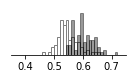

In [3]:
phase = 'enc'
observed_aucs = np.load('scratch/mtpower/%s_%s_auc.npy'%(phase, phase))
null_aucs = np.array([np.load('scratch/mtpower/%s/%s_%s_%s_sessspshuffle_null_aucs.npy'%(s,s,phase,phase)).mean()
                      for s in FR2_valid_subjects])
fig, ax = plot_auc_null(observed_aucs, null_aucs)

# fig.savefig('figures_final/clsf_sessspshuffle_%s_aucnull.pdf'%phase)

In [4]:
print(np.mean(null_aucs), sp.stats.sem(null_aucs))

0.5460118734036168 0.0036215148478131727


### compare original classifier outcomes for forgotten words in serialpos 7 and remembered words in serialpos 17

In [62]:
encresults = [pkl.load(open('scratch/mtpower/%s/%s_enc_enc_clsf_result.pkl'%(subject,subject),'rb')) 
               for subject in FR2_valid_subjects]

In [63]:
sp7forgotten = []
sp17remember = []
for i, subject in enumerate(FR2_valid_subjects):
    yhat = encresults[i]['yhat']
    events = encresults[i]['events']
    x = yhat[(events['serialpos']==7)&(events['recalled']==0)]
    y = yhat[(events['serialpos']==17)&(events['recalled']==1)]
    sp7forgotten.append(x.mean())
    sp17remember.append(y.mean())

In [64]:
scipy.stats.ttest_rel(sp7forgotten, sp17remember)

Ttest_relResult(statistic=-2.676032196239318, pvalue=0.008901492117129569)

Text(0, 0.5, 'Classifier Output')

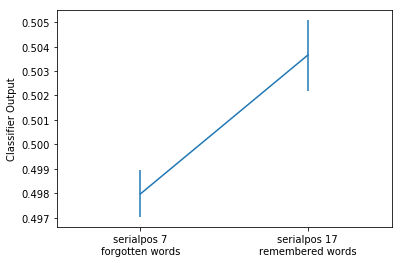

In [65]:
fig, ax = plt.subplots()
ax.errorbar([0,1], [np.mean(sp7forgotten), np.mean(sp17remember)], yerr=[scipy.stats.sem(sp7forgotten), scipy.stats.sem(sp17remember)])
ax.set_xticks([0,1])
ax.set_xticklabels(['serialpos 7\nforgotten words','serialpos 17\nremembered words'])
ax.set_xlim([-0.5,1.5])
ax.set_ylabel('Classifier Output')

In [577]:
# fig.savefig('figures_final/7n17.pdf')

### alternative classification: one per list position

In [ ]:
def FR2_individual_classifier_persp(subject):
    
    # global flags
    train_phase = 'enc'
    test_phase = 'ret'
    ret_type = ['ci', 'cp', 'ce', 'pe'][0] # 'correct vs. incorrect', 'correct vs. pli', 'correct vs. eli', 'pli vs. eli'

    import pickle as pkl
    import numpy as np
    import pandas as pd
    import xarray as xr
    from sklearn.metrics import roc_auc_score
    
    from constants import best_C
    from utils import load_feature, divide_folds, compute_activation, leave_one_session_out_forward_model

    train_features = load_feature(subject, task_phase=train_phase, ret_type=ret_type,
                                  exclude_sessions=[23], exclude_freq=[2.0], 
                                  exclude_peripheral_channels=True, stack_feature=True)
    test_features = load_feature(subject, task_phase=test_phase, ret_type=ret_type,
                                  exclude_sessions=[23], exclude_freq=[2.0], 
                                  exclude_peripheral_channels=True, stack_feature=True)
    
    train_label = 'recalled' if train_phase=='enc' else 'rec_label'
    test_label = 'recalled' if test_phase=='enc' else 'rec_label'
    
    for serialpos in range(1,25):
        
        train_features = train_features.sel(events=train_features.events.values['serialpos']==serialpos)
        test_features = test_features.sel(events=test_features.events.values['serialpos']==serialpos)
        
        y_hat, y, weights, activations = leave_one_session_out_forward_model(train_features=train_features, 
                                                                             train_label=train_label, 
                                                                             test_features=test_features, 
                                                                             test_label=test_label,
                                                                             C=best_C)
        # compute average weights and average activation values
        avgW = xr.DataArray(weights.mean(0), dims=('features'), coords={'features':test_features.features})
        avgW = avgW.unstack('features')
        avgA = xr.DataArray(activations.mean(0), dims=('features'), coords={'features':test_features.features})
        avgA = avgA.unstack('features')

        auc = roc_auc_score(y, y_hat)

        subject_loso_result = {}
        subject_loso_result['auc'] = auc
        subject_loso_result['y'] = y
        subject_loso_result['yhat'] = y_hat
        subject_loso_result['events'] = test_features.events.values
        subject_loso_result['avgW'] = avgW
        subject_loso_result['avgA'] = avgA

        if train_phase == 'ret':
            train_phase = train_phase + ret_type
        if test_phase == 'ret':
            test_phase = test_phase + ret_type

        outputf = 'scratch/mtpower/%s/%s_%s_%s_sp%d_clsf_result.pkl' % (subject, subject, train_phase, test_phase, serialpos)
        # pkl.dump(subject_loso_result, open(outputf, 'wb'))
        
def FR2_individual_classifier_listpos(subject):
    
    # global flags
    train_phase = 'enc'
    test_phase = 'ret'
    ret_type = ['ci', 'cp', 'ce', 'pe'][0] # 'correct vs. incorrect', 'correct vs. pli', 'correct vs. eli', 'pli vs. eli'

    import pickle as pkl
    import numpy as np
    import pandas as pd
    import xarray as xr
    from sklearn.metrics import roc_auc_score
    
    from constants import best_C
    from utils import load_feature, divide_folds, compute_activation, leave_one_session_out_forward_model

    train_features = load_feature(subject, task_phase=train_phase, ret_type=ret_type,
                                  exclude_sessions=[23], exclude_freq=[2.0], 
                                  exclude_peripheral_channels=True, stack_feature=True)
    test_features = load_feature(subject, task_phase=test_phase, ret_type=ret_type,
                                  exclude_sessions=[23], exclude_freq=[2.0], 
                                  exclude_peripheral_channels=True, stack_feature=True)
    
    train_label = 'recalled' if train_phase=='enc' else 'rec_label'
    test_label = 'recalled' if test_phase=='enc' else 'rec_label'
    
    # truncate the events within a serialposition range or recall time range
    if train_phase=='enc':
        train_features = train_features.sel(events=(train_features.events.values['serialpos']>=21)&(train_features.events.values['serialpos']<=24))
    if test_phase=='enc':
        test_features = test_features.sel(events=(test_features.events.values['serialpos']>=21)&(test_features.events.values['serialpos']<=24))
    if train_phase=='ret':
        train_features = train_features.sel(events=(train_features.events.values['rectime']>52500)&(train_features.events.values['rectime']<=75000))
    if test_phase=='ret':
        test_features = test_features.sel(events=(test_features.events.values['rectime']>52500)&(test_features.events.values['rectime']<=75000))

    y_hat, y, weights, activations = leave_one_session_out_forward_model(train_features=train_features, 
                                                                         train_label=train_label, 
                                                                         test_features=test_features, 
                                                                         test_label=test_label,
                                                                         C=best_C)
    # compute average weights and average activation values
    avgW = xr.DataArray(weights.mean(0), dims=('features'), coords={'features':test_features.features})
    avgW = avgW.unstack('features')
    avgA = xr.DataArray(activations.mean(0), dims=('features'), coords={'features':test_features.features})
    avgA = avgA.unstack('features')

    auc = roc_auc_score(y, y_hat)

    subject_loso_result = {}
    subject_loso_result['auc'] = auc
    subject_loso_result['y'] = y
    subject_loso_result['yhat'] = y_hat
    subject_loso_result['events'] = test_features.events.values
    subject_loso_result['avgW'] = avgW
    subject_loso_result['avgA'] = avgA

    if train_phase == 'ret':
        train_phase = train_phase + ret_type
    if test_phase == 'ret':
        test_phase = test_phase + ret_type

    # outputf = 'scratch/mtpower/%s/%s_%s_%s_sp21-24_clsf_result.pkl' % (subject, subject, train_phase, test_phase)
    outputf = 'scratch/mtpower/%s/%s_%s_%s_rt52500-75000_clsf_result.pkl' % (subject, subject, train_phase, test_phase)
    # pkl.dump(subject_loso_result, open(outputf, 'wb'))

In [ ]:
subjects = FR2_valid_subjects
njobs = len(subjects)
cpj = 1
with cluster_helper.cluster.cluster_view(scheduler='sge', queue='RAM.q', 
                                         num_jobs=njobs, cores_per_job=cpj) as view:
    result = view.map(FR2_individual_classifier_listpos, subjects)

In [23]:
# concat auc across all

phase = 'enc'
sp_aucs = np.ones((24, 88)) * np.nan
for sp in range(1,25):
    for i, subject in enumerate(FR2_valid_subjects):
        f = 'scratch/mtpower/%s/%s_%s_%s_sp%d_clsf_result.pkl' % (subject, subject, phase, phase, sp)
        sp_aucs[sp-1, i] = pkl.load(open(f, 'rb'))['auc']

(0.5, 0.6)

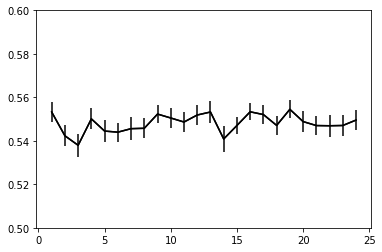

In [24]:
fig, ax = plt.subplots()
ax.plot(range(1,25), sp_aucs.mean(1), color='k')
ax.errorbar(range(1,25), sp_aucs.mean(1), yerr=scipy.stats.sem(sp_aucs, 1), color='k')
ax.set_ylim((0.5, 0.6))

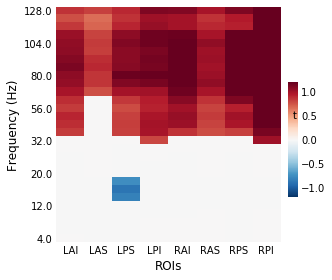

In [44]:
phase = 'enc'

result = []
for subject in FR2_valid_subjects:

    try:
        f = 'scratch/mtpower/%s/%s_%s_%s_rt52500-75000_clsf_result.pkl' % (subject, subject, phase, phase)
        values = pkl.load(open(f, 'rb'))['avgA']

        values = split_ROIs(values, sys='biosemi' if int(subject[-3:])>330 else 'egi')
        result.append(values)
    except:
        continue

fig, ax = plot_heatmap_contrast(result, vmin=-1.2, vmax=1.2)
# fig.savefig('figures/clsf_ret_rt52500-75000.pdf')

### Classification with L1 penalty

In [ ]:
def search_regularization_hyperparam(sys='egi'):
    
    import warnings
    warnings.filterwarnings('ignore')
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import auc, roc_curve, roc_auc_score
    
    from constants import non_peripheral_egi, non_peripheral_biosemi
    from utils import special_concat, load_feature
    
    # use the 24th session to search for good inverse regularization param
    # separately for egi and biosemi sessions
    
    # candidate Cs
    Cs = np.logspace(np.log10(1e-7),np.log10(1e0), num = 10)
    
    if sys == 'egi':
        subjects_all = FR2_valid_subjects[:53]
    
    elif sys == 'biosemi':
        subjects_all = FR2_valid_subjects[53:]
    
    def get_enc_features():
        # 24th session from all participants + leave one subject out
        
        power_all = []
        for subject in subjects_all:
            x = load_feature(subject, task_phase='enc', 
                             exclude_peripheral_channels=True, stack_feature=True)
            
            if 23 not in np.unique(x.events.values['session']): continue
            x = x.sel(events=x.events.values['session']==23)
            power_all.append(x)
        
        power_all = special_concat(power_all)
        return power_all
    
    def divide_folds(subjects, nfold):
        n = int(np.floor(len(subjects) / nfold))
        folds = []
        for i in range(0, len(subjects), n):
            folds.append(subjects[i:i+n])
        return np.array(folds)
    
    def leave_one_subject_out(train_features, test_features, C):
        
        probas = np.empty(len(test_features)) # however many events in data
        labels = np.empty(len(test_features))
        probas.fill(np.nan)
        labels.fill(np.nan)
        
        folds = divide_folds(np.unique(train_features.events.values['subject']),
                             len(np.unique(train_features.events.values['subject']))) # LOSO

        for fold in folds:

            train = np.array([False if s in fold else True for s in train_features.events.values['subject']])
            test = np.array([True if s in fold else False for s in test_features.events.values['subject']])

            train_data = train_features.sel(events=train).copy()
            test_data = test_features.sel(events=test).copy()

            X = train_data.values
            y = train_data.events.values['recalled']

            lr = LogisticRegression(C=C, class_weight='balanced',
                                    penalty='l1', solver='liblinear')
            lr = lr.fit(X, y)

            probas[test] = lr.predict_proba(test_data)[:, 1]
            labels[test] = test_data.events.values['recalled']

        return (probas, labels)
    
    train_features = get_enc_features()
    test_features = train_features.copy()
    
    aucs = {}
    for i, C in enumerate(Cs):
        print(C)
        y_hat, y = leave_one_subject_out(train_features=train_features, 
                                         test_features=test_features,
                                         C=C)
        auc = roc_auc_score(y, y_hat)
        aucs[i] = {'C':C, 'auc':auc}
        
    return aucs

In [ ]:
egi_aucs = search_regularization_hyperparam(sys='egi')
biosemi_aucs = search_regularization_hyperparam(sys='biosemi')

1e-07
5.994842503189409e-07
3.5938136638046257e-06
2.1544346900318867e-05
0.0001291549665014884
0.000774263682681127
0.004641588833612782


In [ ]:
# egi_aucs
# {0: {'C': 1e-07, 'auc': 0.5},
#  1: {'C': 5.994842503189409e-07, 'auc': 0.5},
#  2: {'C': 3.5938136638046257e-06, 'auc': 0.5},
#  3: {'C': 2.1544346900318867e-05, 'auc': 0.5},
#  4: {'C': 0.0001291549665014884, 'auc': 0.5},
#  5: {'C': 0.000774263682681127, 'auc': 0.5},
#  6: {'C': 0.004641588833612782, 'auc': 0.5488933406861408},
#  7: {'C': 0.02782559402207126, 'auc': 0.5436093384953409},
#  8: {'C': 0.1668100537200059, 'auc': 0.5297229723214072}}

In [ ]:
# biosemi_aucs
# {0: {'C': 1e-07, 'auc': 0.5},
#  1: {'C': 5.994842503189409e-07, 'auc': 0.5},
#  2: {'C': 3.5938136638046257e-06, 'auc': 0.5},
#  3: {'C': 2.1544346900318867e-05, 'auc': 0.5},
#  4: {'C': 0.0001291549665014884, 'auc': 0.5},
#  5: {'C': 0.000774263682681127, 'auc': 0.5},
#  6: {'C': 0.004641588833612782, 'auc': 0.5445443713204438},
#  7: {'C': 0.02782559402207126, 'auc': 0.5399761538997616},
#  8: {'C': 0.1668100537200059, 'auc': 0.5184124643091247}}

In [137]:
def FR2_individual_classifier_l1_penalty(subject):
    
    # global flags
    train_phase = 'enc'
    test_phase = 'ret'
    ret_type = ['ci', 'cp', 'ce', 'pe'][0] # 'correct vs. incorrect', 'correct vs. pli', 'correct vs. eli', 'pli vs. eli'

    import pickle as pkl
    import numpy as np
    import pandas as pd
    import xarray as xr
    from sklearn.metrics import roc_auc_score
    
    from utils import load_feature, divide_folds, compute_activation, leave_one_session_out_forward_model

    train_features = load_feature(subject, task_phase=train_phase, ret_type=ret_type,
                                  exclude_sessions=[23], exclude_freq=[2.0], 
                                  exclude_peripheral_channels=True, stack_feature=True)
    test_features = load_feature(subject, task_phase=test_phase, ret_type=ret_type,
                                  exclude_sessions=[23], exclude_freq=[2.0], 
                                  exclude_peripheral_channels=True, stack_feature=True)
    
    train_label = 'recalled' if train_phase=='enc' else 'rec_label'
    test_label = 'recalled' if test_phase=='enc' else 'rec_label'
    
    y_hat, y, weights, activations = leave_one_session_out_forward_model(train_features=train_features, 
                                                                         train_label=train_label, 
                                                                         test_features=test_features, 
                                                                         test_label=test_label,
                                                                         C=np.logspace(np.log10(1e-7),np.log10(1e0),num=10)[6],
                                                                         regularization='l1')
    # compute average weights and average activation values
    avgW = xr.DataArray(weights.mean(0), dims=('features'), coords={'features':test_features.features})
    avgW = avgW.unstack('features')
    avgA = xr.DataArray(activations.mean(0), dims=('features'), coords={'features':test_features.features})
    avgA = avgA.unstack('features')
    
    auc = roc_auc_score(y, y_hat)
    
    subject_loso_result = {}
    subject_loso_result['auc'] = auc
    subject_loso_result['y'] = y
    subject_loso_result['yhat'] = y_hat
    subject_loso_result['events'] = test_features.events.values
    subject_loso_result['avgW'] = avgW
    subject_loso_result['avgA'] = avgA
    
    if train_phase == 'ret':
        train_phase = train_phase + ret_type
    if test_phase == 'ret':
        test_phase = test_phase + ret_type

    outputf = 'scratch/mtpower/%s/%s_%s_%s_l1_clsf_result.pkl' % (subject, subject, train_phase, test_phase)
    # pkl.dump(subject_loso_result, open(outputf, 'wb'))
    
    return auc

def FR2_individual_classifier_l1_nullauc(subject):
    
    # global flags
    train_phase = 'enc'
    test_phase = 'enc'
    ret_type = ['ci', 'cp', 'ce', 'pe'][0] # 'correct vs. incorrect', 'correct vs. pli', 'correct vs. eli', 'pli vs. eli'
    n_tests = 100
    
    import pickle as pkl
    import numpy as np
    import pandas as pd
    import xarray as xr
    from sklearn.metrics import roc_auc_score
    
    from utils import load_feature, divide_folds, compute_activation, \
                      leave_one_session_out_forward_model, shuffle_labels
    
    train_features = load_feature(subject, task_phase=train_phase, ret_type=ret_type,
                                  exclude_sessions=[23], exclude_freq=[2.0], 
                                  exclude_peripheral_channels=True, stack_feature=True)
    test_features = load_feature(subject, task_phase=test_phase, ret_type=ret_type,
                                  exclude_sessions=[23], exclude_freq=[2.0], 
                                  exclude_peripheral_channels=True, stack_feature=True)
    
    train_label = 'recalled' if train_phase=='enc' else 'rec_label'
    test_label = 'recalled' if test_phase=='enc' else 'rec_label'
    
    # save a copy of original events
    original_events = train_features.events.values.copy()
    
    # perform n_tests many of permutation tests
    aucs_null = np.zeros(n_tests)
    for i in range(len(aucs_null)):

        shuffled_events = shuffle_labels(original_events.copy(), train_label)
        train_features.coords['events'] = shuffled_events

        y_hat, y, weights, activations = leave_one_session_out_forward_model(train_features=train_features, 
                                                                             train_label=train_label, 
                                                                             test_features=test_features, 
                                                                             test_label=test_label,
                                                                             C=np.logspace(np.log10(1e-7),np.log10(1e0),num=10)[6],
                                                                             regularization='l1')
        aucs_null[i] = roc_auc_score(y, y_hat)
    
    if train_phase == 'ret':
        train_phase = train_phase + ret_type
    if test_phase == 'ret':
        test_phase = test_phase + ret_type

    outputf = 'scratch/mtpower/%s/%s_%s_%s_l1_null_aucs.npy' % (subject, subject, train_phase, test_phase)
    # np.save(outputf, aucs_null)
    
def test_l1_clsf_significance(trainphase, testphase):
    
    def binomial_test(pvals, alpha=0.05):
        count = (pvals < alpha).sum()
        group_p = sp.stats.binom_test(count, len(pvals), 0.05, alternative='greater')
        return group_p
    
    subjects = FR2_valid_subjects
    print('Evaluating FR2 L1 classifier performance for %d subjects...' % (len(subjects)))
    print('    Train phase: %s    Test phase: %s' % (trainphase, testphase))
    
    true_aucs = np.load('scratch/mtpower/%s_%s_l1_auc.npy'%(trainphase, testphase))
    print('    Mean AUC:', '%.2f'%np.mean(true_aucs), '  +-SE:', sp.stats.sem(true_aucs))
    
    null_aucs = np.array([np.load('scratch/mtpower/%s/%s_%s_%s_l1_null_aucs.npy'% (subject, subject, trainphase, testphase))
                          for subject in subjects])
    
    pvals = np.array([ (null_aucs[i]>true_aucs[i]).sum()/float(len(null_aucs)) for i in range(len(true_aucs))])
    all_alpha = [0.01, 0.05]
    counts = []
    
    for alpha in all_alpha:
        count = (pvals < alpha).sum()
        counts.append(count)
    
    # remove overlaps 
    # - those who are significant at 0.001 are subtracted from 0.01 and 0.05
    # - those who are significant at 0.01 are subtracted from 0.05
    counts[1] = counts[1]-counts[0]
    
    for i, alpha in enumerate(all_alpha):
        print('    alpha=%.03f: \t %0.2f significant' % (alpha, counts[i]))
    
    print('    p<0.05: ', len(subjects[pvals<0.05])) # subjects[pvals<0.05])
    
    group_p = binomial_test(pvals)
    print('    group binomial test:  p=%.11f, %s' % (group_p, 'significant' if group_p<0.05 else'non significant'))
    group_t, group_p = scipy.stats.ttest_rel(true_aucs, null_aucs.mean(1))
    print('    group t-test: t=%f, p=%f, %s' % (group_t, group_p, 'significant' if group_p<0.05 else'non significant'))
    
    return (subjects[pvals<0.05], subjects[pvals>=0.05])

In [24]:
subjects = FR2_valid_subjects
njobs = len(subjects)
cpj = 1
with cluster_helper.cluster.cluster_view(scheduler='sge', queue='RAM.q', 
                                         num_jobs=njobs, cores_per_job=cpj) as view:
    result = view.map(FR2_classifier_l1_penalty, subjects)

57 Engines running
Sending a shutdown signal to the controller and engines.


OSError: [Errno 16] Device or resource busy: '.nfs0000004a00c818100000ef09'

In [30]:
# concat auc across all

phase = 'retci'

l1_aucs = []
for subject in FR2_valid_subjects:
    f = 'scratch/mtpower/%s/%s_%s_%s_l1_clsf_result.pkl' % (subject, subject, phase, phase)
    l1_aucs.append(pkl.load(open(f, 'rb'))['auc'])

l1_aucs = np.array(l1_aucs)
# np.save('scratch/mtpower/%s_%s_l1_auc.npy'%(phase,phase), l1_aucs)

In [5]:
aucs = np.load('scratch/mtpower/enc_enc_auc.npy')
l1_aucs = np.load('scratch/mtpower/enc_enc_l1_auc.npy')

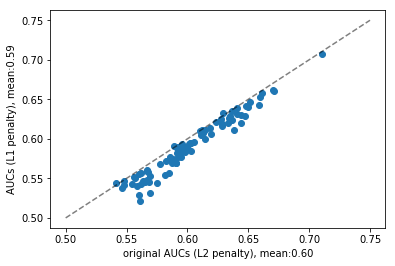

In [6]:
fig, ax = plt.subplots()
ax.scatter(aucs, l1_aucs)
ax.plot([0.5,0.75],[0.5,0.75], '--', c='black', alpha=0.5)
ax.set_xlabel('original AUCs (L2 penalty), mean:%.2f'%aucs.mean())
ax.set_ylabel('AUCs (L1 penalty), mean:%.2f'%l1_aucs.mean())
# fig.savefig('figures/l1_encoding_auc.pdf')

In [7]:
aucs = np.load('scratch/mtpower/retci_retci_auc.npy')
l1_aucs = np.load('scratch/mtpower/retci_retci_l1_auc.npy')

Text(0, 0.5, 'AUCs (L1 penalty), mean:0.56')

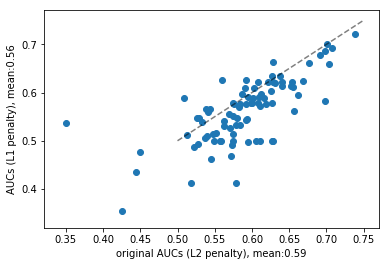

In [8]:
fig, ax = plt.subplots()
ax.scatter(aucs, l1_aucs)
ax.plot([0.5,0.75],[0.5,0.75], '--', c='black', alpha=0.5)
ax.set_xlabel('original AUCs (L2 penalty), mean:%.2f'%aucs.mean())
ax.set_ylabel('AUCs (L1 penalty), mean:%.2f'%l1_aucs.mean())
# fig.savefig('figures/l1_retrieval_auc.pdf')

In [143]:
phase = 'retci'
sig_subjects = test_l1_clsf_significance(phase, phase)[0] # subjects whose classifier is significant with p<0.05

result = []
for subject in sig_subjects:
    f = 'scratch/mtpower/%s/%s_%s_%s_l1_clsf_result.pkl' % (subject, subject, phase, phase)
    values = pkl.load(open(f, 'rb'))['avgA']
    values = split_ROIs(values, sys=get_eeg_sys(subject))
    result.append(values)

Evaluating FR2 L1 classifier performance for 88 subjects...
    Train phase: retci    Test phase: retci
    Mean AUC: 0.56   +-SE: 0.007140369046883959
    alpha=0.010: 	 44.00 significant
    alpha=0.050: 	 14.00 significant
    p<0.05:  58
    group binomial test:  p=0.00000000000, significant
    group t-test: t=8.828260, p=0.000000, significant


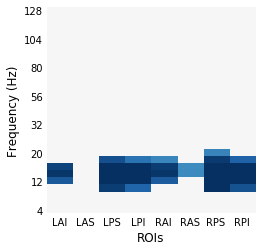

In [142]:
# encoding
fig, ax = plot_heatmap_contrast(result, vmin=-1.2, vmax=1.2, colorbar=False, figsize=[4.2,3.6])
# fig.savefig('figures_final/l1_clsf_atv_%s.pdf'%phase)

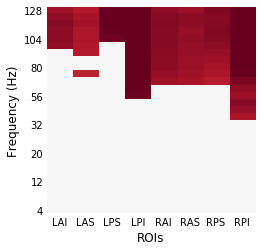

In [144]:
# retrieval
fig, ax = plot_heatmap_contrast(result, vmin=-1.2, vmax=1.2, colorbar=False, figsize=[4.2,3.6])
# fig.savefig('figures_final/l1_clsf_atv_%s.pdf'%phase)

#### L1 classifier list dynamics (including everyone, didn't run null AUCs yet

In [146]:
l1_enc_sig_subjects = test_l1_clsf_significance('enc', 'enc')[0]
l1_ret_sig_subjects = test_l1_clsf_significance('retci', 'retci')[0]

Evaluating FR2 L1 classifier performance for 88 subjects...
    Train phase: enc    Test phase: enc
    Mean AUC: 0.59   +-SE: 0.003978945279857634
    alpha=0.010: 	 88.00 significant
    alpha=0.050: 	 0.00 significant
    p<0.05:  88
    group binomial test:  p=0.00000000000, significant
    group t-test: t=22.776402, p=0.000000, significant
Evaluating FR2 L1 classifier performance for 88 subjects...
    Train phase: retci    Test phase: retci
    Mean AUC: 0.56   +-SE: 0.007140369046883959
    alpha=0.010: 	 44.00 significant
    alpha=0.050: 	 14.00 significant
    p<0.05:  58
    group binomial test:  p=0.00000000000, significant
    group t-test: t=8.828260, p=0.000000, significant


In [13]:
labeled_events = pkl.load(open('FR2_all_events_clustered.pkl','rb'))
enc_labeled_events = labeled_events[labeled_events['type']=='WORD']
ret_labeled_events = labeled_events[labeled_events['type']=='REC_WORD']

In [145]:
encresults = [pkl.load(open('scratch/mtpower/%s/%s_enc_enc_l1_clsf_result.pkl'%(subject,subject),'rb')) 
               for subject in FR2_valid_subjects]

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [154]:
# encoding output by clustering type and serial position - data 
BCall = []
TCall = []
SCall = []
NCall = []
NRall = []
for i, subject in enumerate(l1_enc_sig_subjects):
    print(subject, end=',')
    
    def get_cluster_type(select_events, all_events):
        subject_data = all_events[all_events['subject']==subject]
        subject_data = subject_data.sort_values('mstime')
        events_index = np.in1d(subject_data['mstime'].values, select_events['mstime'])
        return subject_data['cluster_type'][events_index]
    
    def mean_yhat(all_yhat, events):
        result = []
        for sess in np.unique(events['session']):
            # if clean data: some sessions are missing items
            if subject == 'LTP246' and sess == 6: # LTP246 sess 6 trial 4 has only one item
                sess_index = (events['session']==sess) & (events['trial']!=4)
            elif subject == 'LTP258' and sess == 17: # LTP258 sess 17 trial 1 has only 14 items
                sess_index = (events['session']==sess) & (events['trial']!=1)
            else:
                sess_index = events['session']==sess
            n_list = len(np.unique(events[sess_index]['trial']))
            yhat = all_yhat[sess_index].reshape(n_list, 24)
            result.append(np.nanmean(yhat, 0))
        return np.nanmean(result, 0)
    
    def extract_one_type(yhat, events, conditions, ctype):
        x = yhat.copy()
        x[conditions!=ctype] = np.nan
        x = mean_yhat(x, events)
        return x
    
    yhat = encresults[i]['yhat']
    events = encresults[i]['events']
    conditions = get_cluster_type(events, enc_labeled_events)
    BCall.append(extract_one_type(yhat, events, conditions, 'BC'))
    TCall.append(extract_one_type(yhat, events, conditions, 'TC'))
    SCall.append(extract_one_type(yhat, events, conditions, 'SC'))
    NCall.append(extract_one_type(yhat, events, conditions, 'NC'))
    NRall.append(extract_one_type(yhat, events, conditions, 'NR'))

BCall = np.array(BCall)
TCall = np.array(TCall)
SCall = np.array(SCall)
NCall = np.array(NCall)
NRall = np.array(NRall)

LTP093,LTP106,LTP115,LTP117,LTP123,LTP133,LTP138,LTP207,LTP210,LTP228,LTP229,LTP236,LTP246,LTP249,LTP250,LTP251,LTP258,LTP259,LTP265,LTP269,LTP273,LTP278,LTP279,LTP280,LTP283,LTP285,LTP287,LTP293,LTP296,LTP297,LTP299,LTP301,LTP302,LTP303,LTP304,LTP305,LTP306,LTP307,LTP310,LTP311,LTP312,LTP316,LTP317,LTP318,LTP321,LTP322,LTP323,LTP324,LTP325,LTP326,LTP327,LTP328,LTP329,LTP331,LTP334,LTP336,LTP339,LTP341,LTP342,LTP343,LTP344,LTP346,LTP347,LTP348,LTP349,LTP354,LTP355,LTP357,LTP360,LTP361,LTP362,LTP364,LTP365,LTP366,LTP367,LTP371,LTP372,LTP373,LTP374,LTP376,LTP377,LTP385,LTP386,LTP387,LTP389,LTP390,LTP391,LTP393,

Text(11.75, 0.5, 'Classifier Output')

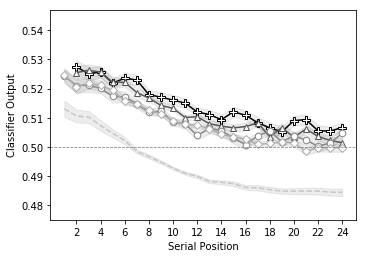

In [155]:
from plot_utils import plot_list_dynamics

values = [BCall, TCall, SCall, NCall, NRall]
labels=['BC','TC','SC','NC','NR']
colors=['k','#555555','#888888','#adadad','#c6c6c6']
markers=['P','^','o','D','']
markersizes=[7.5,6.5,6.5,5.5,0]
linestyles=['-','-','-','-','--']
xticks=np.arange(24)
jitters=[0]*len(values)

value_dict = {}
for i, label in enumerate(labels):
    value_dict[label] = {'value':values[i], 'color':colors[i], 'linestyle':linestyles[i],
                         'marker':markers[i], 'markersize':markersizes[i],
                         'xticks':xticks, 'jitter':jitters[i]}

fig, ax = plot_list_dynamics(value_dict)

ax.set_ylim([0.50,0.54])
ax.set_ylabel('Encoding Classifier Output')

ax.axhline(y=0.5, ls='--', lw=0.75, color='gray')

ax.set_xticks(range(24)[1::2])
ax.set_xticklabels(np.arange(1,25,1)[1::2])
ax.set_ylim([0.475,0.547])
ax.set_xlabel('Serial Position')
ax.set_ylabel('Classifier Output')

In [156]:
# fig.savefig('figures_final/l1_yhat_enc.pdf', bbox_inches="tight")

In [150]:
retciresults = [pkl.load(open('scratch/mtpower/%s/%s_retci_retci_l1_clsf_result.pkl'%(subject,subject),'rb')) 
                 for subject in FR2_valid_subjects]

In [157]:
# retrieval output by clustering type and recall time - data 

CRall = []
BCall = []
TCall = []
SCall = []
NCall = []
INall = []
PIall = []
EIall = []

for i, subject in enumerate(l1_ret_sig_subjects):
    print(subject, end=',')
    
    def get_cluster_type(select_events, all_events):
        subject_data = all_events[all_events['subject']==subject]
        subject_data = subject_data.sort_values('mstime')
        events_index = np.in1d(subject_data['mstime'].values, select_events['mstime'])
        return subject_data['cluster_type'][events_index]
    
    def find_bins(t, bins=np.arange(0, 75.1, 7.5)):
        return np.where(t>bins)[0][-1]
    
    def bin_trial(trial_yhat, bins):
        result = []
        for b in range(10):
            if b not in bins: # no recall in that bin
                result.append(np.nan)
            else:
                result.append(np.nanmean(trial_yhat[bins==b]))
        return np.array(result)
    
    def bin_session(sess_yhat, trial, bins):
        result = []
        for t in np.unique(trial):
            index = trial==t
            trial_result = bin_trial(sess_yhat[index], bins[index])
            result.append(trial_result)
        result = np.array(result)
        return np.nanmean(result,0)
    
    def extract_one_type(yhat, events, conditions, ctype, bins):
        x = yhat.copy()
        if ctype=='CR':
            x[events['intrusion']!=0] = np.nan
        elif ctype=='IN':
            x[events['intrusion']==0] = np.nan
        elif ctype=='PI':
            x[events['intrusion']<=0] = np.nan
        elif ctype=='EI':
            x[events['intrusion']>=0] = np.nan
        else:
            x[conditions!=ctype] = np.nan
        session = events['session']
        trial = events['trial']
        binned_x = []
        for sess in np.unique(session):
            index = session==sess
            sess_x = bin_session(x[index], trial[index], bins[index])
            binned_x.append(sess_x)
        return np.nanmean(binned_x,0)
    
    yhat = retciresults[i]['yhat']
    events = retciresults[i]['events']
    conditions = get_cluster_type(events, ret_labeled_events)

    session = events['session']
    trial = events['trial']
    bins = np.array([find_bins(t/1000.0) for t in events['rectime']])
        
    CRall.append(extract_one_type(yhat, events, conditions, 'CR', bins))
    BCall.append(extract_one_type(yhat, events, conditions, 'BC', bins))
    TCall.append(extract_one_type(yhat, events, conditions, 'TC', bins))
    SCall.append(extract_one_type(yhat, events, conditions, 'SC', bins))
    NCall.append(extract_one_type(yhat, events, conditions, 'NC', bins))
    INall.append(extract_one_type(yhat, events, conditions, 'IN', bins))
    PIall.append(extract_one_type(yhat, events, conditions, 'PI', bins))
    EIall.append(extract_one_type(yhat, events, conditions, 'EI', bins))
    
CRall = np.array(CRall)
INall = np.array(INall)
PIall = np.array(PIall)
EIall = np.array(EIall)
BCall = np.array(BCall)
TCall = np.array(TCall)
SCall = np.array(SCall)
NCall = np.array(NCall)

LTP115,LTP117,LTP123,LTP133,LTP138,LTP207,LTP229,LTP250,LTP251,LTP258,LTP259,LTP265,LTP273,LTP278,LTP280,LTP283,LTP285,LTP287,LTP297,LTP301,LTP302,LTP303,LTP304,LTP306,LTP307,LTP310,LTP312,LTP316,LTP317,LTP318,LTP323,LTP325,LTP327,LTP329,LTP334,LTP336,LTP339,LTP341,LTP342,LTP343,LTP346,LTP348,LTP349,LTP354,LTP357,LTP361,LTP362,LTP364,LTP365,LTP366,LTP367,LTP373,LTP374,LTP377,LTP386,LTP387,LTP389,LTP393,

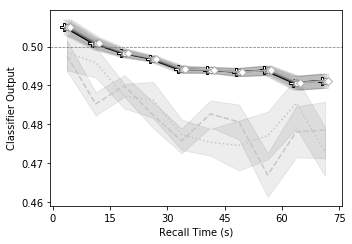

In [158]:
values = [BCall, TCall, SCall, NCall, PIall, EIall]
labels=['BC','TC','SC','NC','PLI','ELI']
colors=['k','#555555','#888888','#adadad','#c6c6c6','#c6c6c6']
markers=['P','^','o','D','','']
markersizes=[7.5,6.5,6.5,5.5,0,0]
linestyles=['-','-','-','-','--',':']
xticks = np.arange(7.5, 75.1, 7.5)-7.5/2
jitters = [-0.9,-0.3,0.3,0.9,0,0]

value_dict = {}
for i, label in enumerate(labels):
    value_dict[label] = {'value':values[i], 'color':colors[i], 'linestyle':linestyles[i],
                         'marker':markers[i], 'markersize':markersizes[i],
                         'xticks':xticks, 'jitter':jitters[i]}

fig, ax = plot_list_dynamics(value_dict)

ax.axhline(0.5, ls='--', lw=0.75, color='gray')
# ax.set_ylim([0.43,0.524])
ax.set_xticks(np.arange(0,76,15))
ax.set_xticklabels(np.arange(0,76,15))
ax.set_xlabel('Recall Time (s)')
ax.set_ylabel('Classifier Output')

# ax.legend(loc=3, fontsize='medium')
fig.tight_layout()

In [159]:
# fig.savefig('figures_final/l1_yhat_retci.pdf', bbox_inches="tight")